# CAB420 Assignment 1A Question 2: Template
Simon Denman (s.denman@qut.edu.au)

## Overview

This notebook provides a brief template for CAB420 Assignment 1A, Question 2. It simply implements the data loading, and splitting the data into the predictors and response. You are to use the data splits defined here in your response.

The template also provides other suggestions around how to approach the problem.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

In [6]:
# load data
train = pd.read_csv('../A1/Data/Q2/training.csv')
val = pd.read_csv('../A1/Data/Q2/validation.csv')
test = pd.read_csv('../A1/Data/Q2/testing.csv')

# pull out X and y data, convert to numpy
X_train = train.iloc[:,1:].to_numpy()
Y_train = train.iloc[:,0].to_numpy()
X_val = val.iloc[:,1:].to_numpy()
Y_val = val.iloc[:,0].to_numpy()
X_test = test.iloc[:,1:].to_numpy()
Y_test = test.iloc[:,0].to_numpy()

Before NaN deletion (198, 28) (164, 28) (161, 28)
After NaN deletion, should be the same (198, 28) (164, 28) (161, 28)


Text(0, 0.5, 'Data')

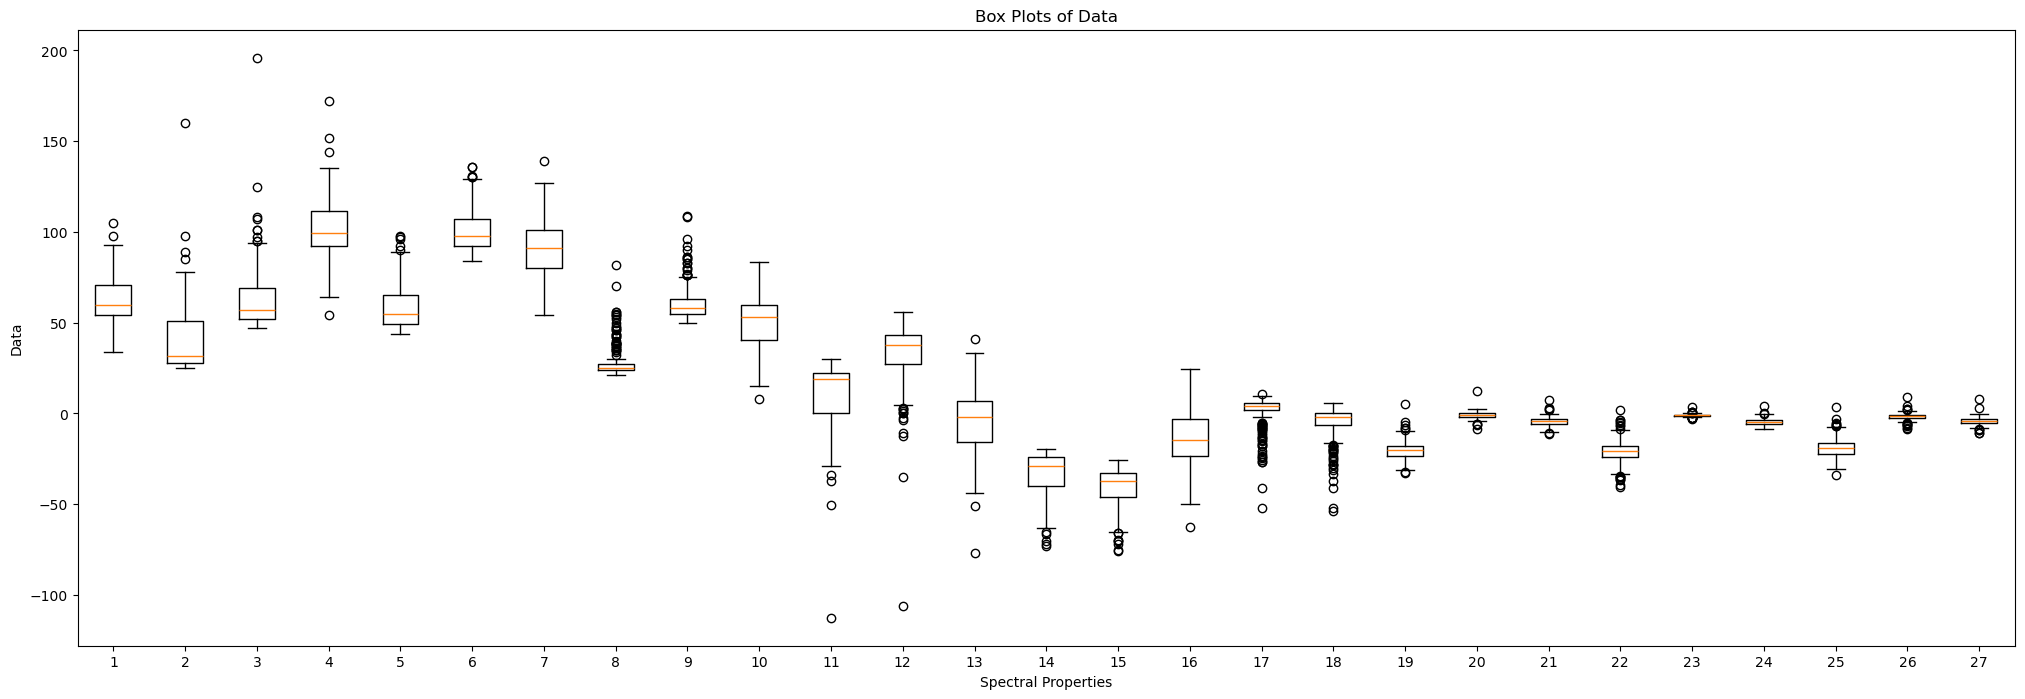

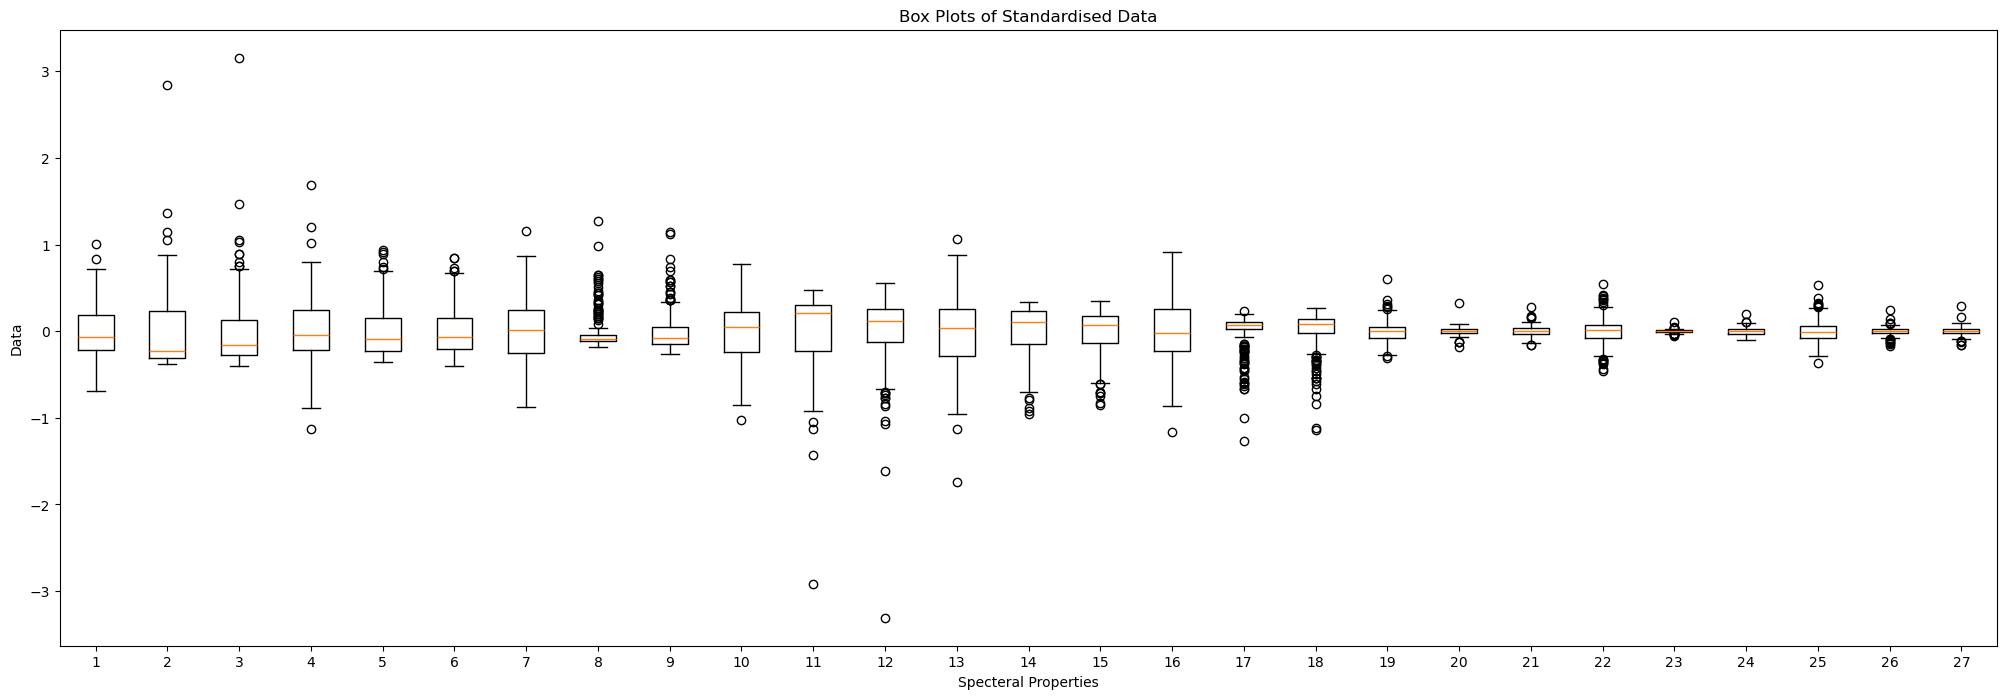

In [7]:
# If you wish to pre-process the data, do so here. In your write-up, outline why you choose to do, or choose not to do, any
# pre-processing

# Again lets search for any NaN values and remove them
# Remove any type of NaN value from the dataset for a sanity check
print("Before NaN deletion", train.shape, val.shape, test.shape)
train = train.dropna(axis=0)
val = val.dropna(axis=0)
test = test.dropna(axis=0)
print("After NaN deletion, should be the same", train.shape, val.shape, test.shape)

# Creating a box plot to determine if standardisation is required on the data set, this is important for technqiues such as K nearest and SVM since they are distance based, and large values could distort
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train);
ax.set_title("Box Plots of Data")
ax.set_xlabel("Spectral Properties")
ax.set_ylabel("Data")

# We can see we several class imbalances here, particulary looking at the smaller values. Evident in property 8, 17, 18, 19 20, 21, 22, 23, 24, 25, 26, 27
# Normalisation 
# Normalize the data
X_train_min = np.min(X_train, axis=0)
X_train_max = np.max(X_train, axis=0)

X_train_norm = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test_norm = (X_test - X_train_min) / (X_train_max - X_train_min)
X_val_norm = (X_val - X_train_min) / (X_train_max - X_train_min)

# Now we are going to standardise and then output the resulting box plot
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train)
X_train_std = (X_train - mu) / sigma;
X_test_std = (X_test - mu) / sigma;
X_val_std = (X_val - mu) / sigma;
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train_std);
ax.set_title("Box Plots of Standardised Data")
ax.set_xlabel("Specteral Properties")
ax.set_ylabel("Data")

Text(0, 0.5, 'Amount')

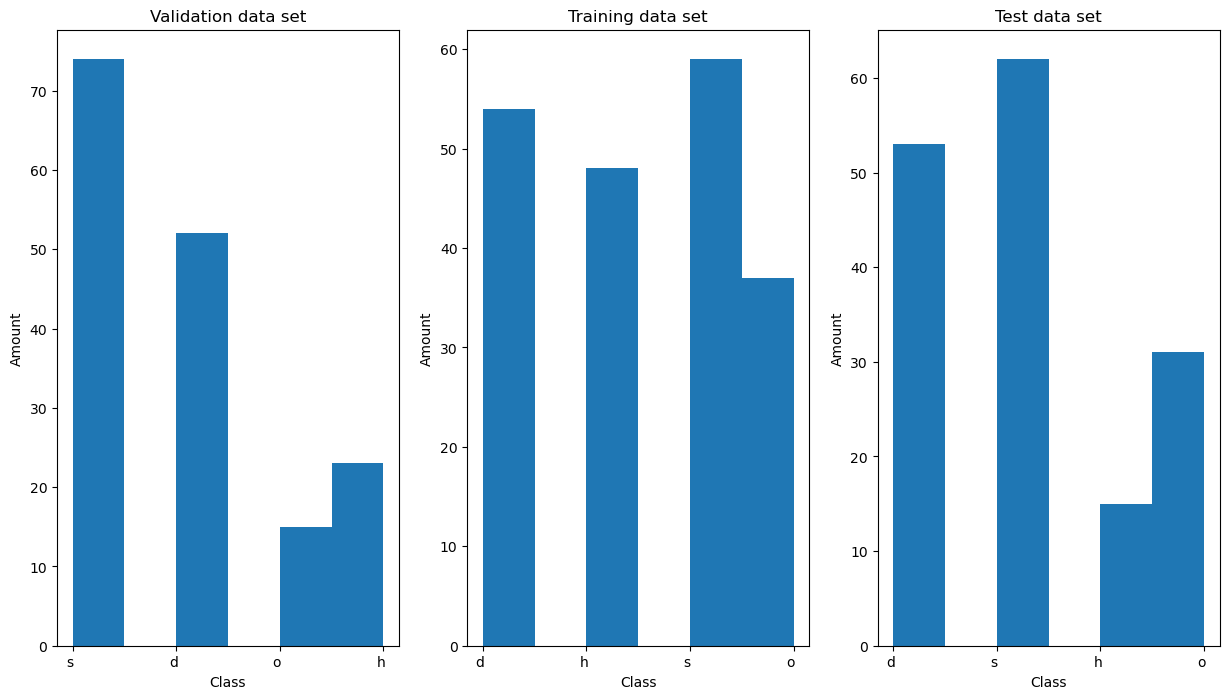

In [8]:
# Looking at class imbalances of the Y data
# having a look at class imbalance
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(1, 3, 2)
ax.hist(Y_train, 6)
ax.set_title('Training data set')
ax.set_xlabel('Class')
ax.set_ylabel('Amount')
ax = fig.add_subplot(1, 3, 3)
ax.hist(Y_test, 6)
ax.set_title('Test data set')
ax.set_xlabel('Class')
ax.set_ylabel('Amount')
ax = fig.add_subplot(1, 3, 1)
ax.hist(Y_val, 6)
ax.set_title('Validation data set')
ax.set_xlabel('Class')
ax.set_ylabel('Amount')
# We can clearly see class imbalance especially, with class h and o in the test and validation set -> RESEARCH WHAT IMPACT IT MAY HAVE

# Grid Search PredefinedSplit

In [9]:
# Q2 asks you to use a grid search for each model. You are to evaluate the models on the validation set, and train on the train
# set. If you wish to use sklearn's GridSearchCV, you will need to setup a PredefinedSplit to pass into this. An appropraite
# PredefinedSplit object is created below.
X_train_and_val = np.vstack((X_train, X_val))
Y_train_and_val = np.hstack((Y_train, Y_val))
mask = np.zeros(len(Y_train_and_val))
mask[0:len(Y_train)] = -1
train_val_split = PredefinedSplit(mask)

# Standardised Predefined Split
X_train_and_val_std = np.vstack((X_train_std, X_val_std))
mask = np.zeros(len(Y_train_and_val))
mask[0:len(Y_train)] = -1
train_val_split_std = PredefinedSplit(mask)

# Normalised Predefined Split
X_train_and_val_norm = np.vstack((X_train_norm, X_val_norm))
mask = np.zeros(len(Y_train_and_val))
mask[0:len(Y_train)] = -1
train_val_split_norm = PredefinedSplit(mask)

# Evaluation Function
- Prints out confusion matrix for training and testing data
- Prints the precision, recall, f1 for test data

In [10]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

# Eval Function To Grab Only testing confusion matrix and have better naming convention

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Function to plot testing confusion matrices for multiple models on the same subplot
def eval_model_TEST(model, X_train, Y_train, X_test, Y_test, title='Testing Set Performance'):
    # Create a figure with a specific size
    fig, ax = plt.subplots(figsize=[10, 8])

    # Plot the confusion matrix for the testing data in the same subplot
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    
    # Set the custom title for the testing confusion matrix
    conf.ax_.set_title(title)
    
    # Print the classification report for the test data
    print(classification_report(Y_test, model.predict(X_test)))

    # Return the testing confusion matrix so it can be reused
    return conf.confusion_matrix

# CKNN Modelling
This uses distance therefore, we need to use standardisation

# No Standardisation

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

          d        0.83      0.83      0.83        53
          h        0.61      0.93      0.74        15
          o        0.92      0.71      0.80        31
          s        0.85      0.84      0.85        62

    accuracy                           0.82       161
   macro avg       0.80      0.83      0.80       161
weighted avg       0.83      0.82      0.82       161



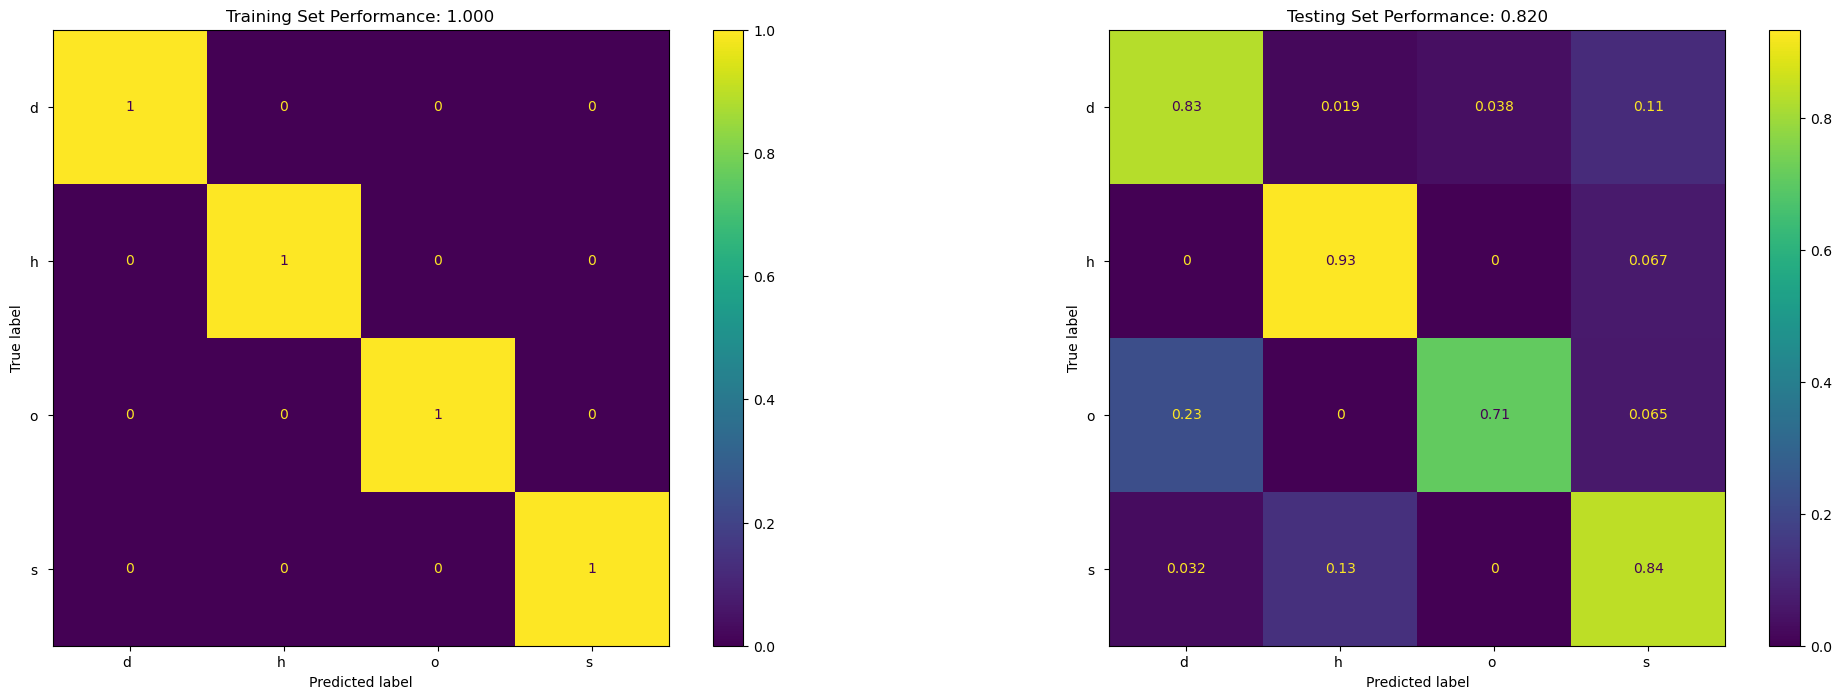

In [12]:
# Train your CKNN. You should consider the following parameters at least:
#  - K
#  - Distance Metric
#  - Weighting Scheme
# Please note, you'd don't need to find the "perfect" parameters. The grid search does not need to consider every possible value,
# and can be quite coarse to avoid long run-times. You may also wish to conduct a rough search first, and then a refined search, 
# though this is not required.

param_grid = {
    'n_neighbors': [1,5,10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn = GridSearchCV(
    estimator=cknn,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn, X_train, Y_train, X_test, Y_test)

# Refining Parameters for Best Results - FINAL CKNN

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

          d        0.83      0.83      0.83        53
          h        0.61      0.93      0.74        15
          o        0.92      0.71      0.80        31
          s        0.85      0.84      0.85        62

    accuracy                           0.82       161
   macro avg       0.80      0.83      0.80       161
weighted avg       0.83      0.82      0.82       161



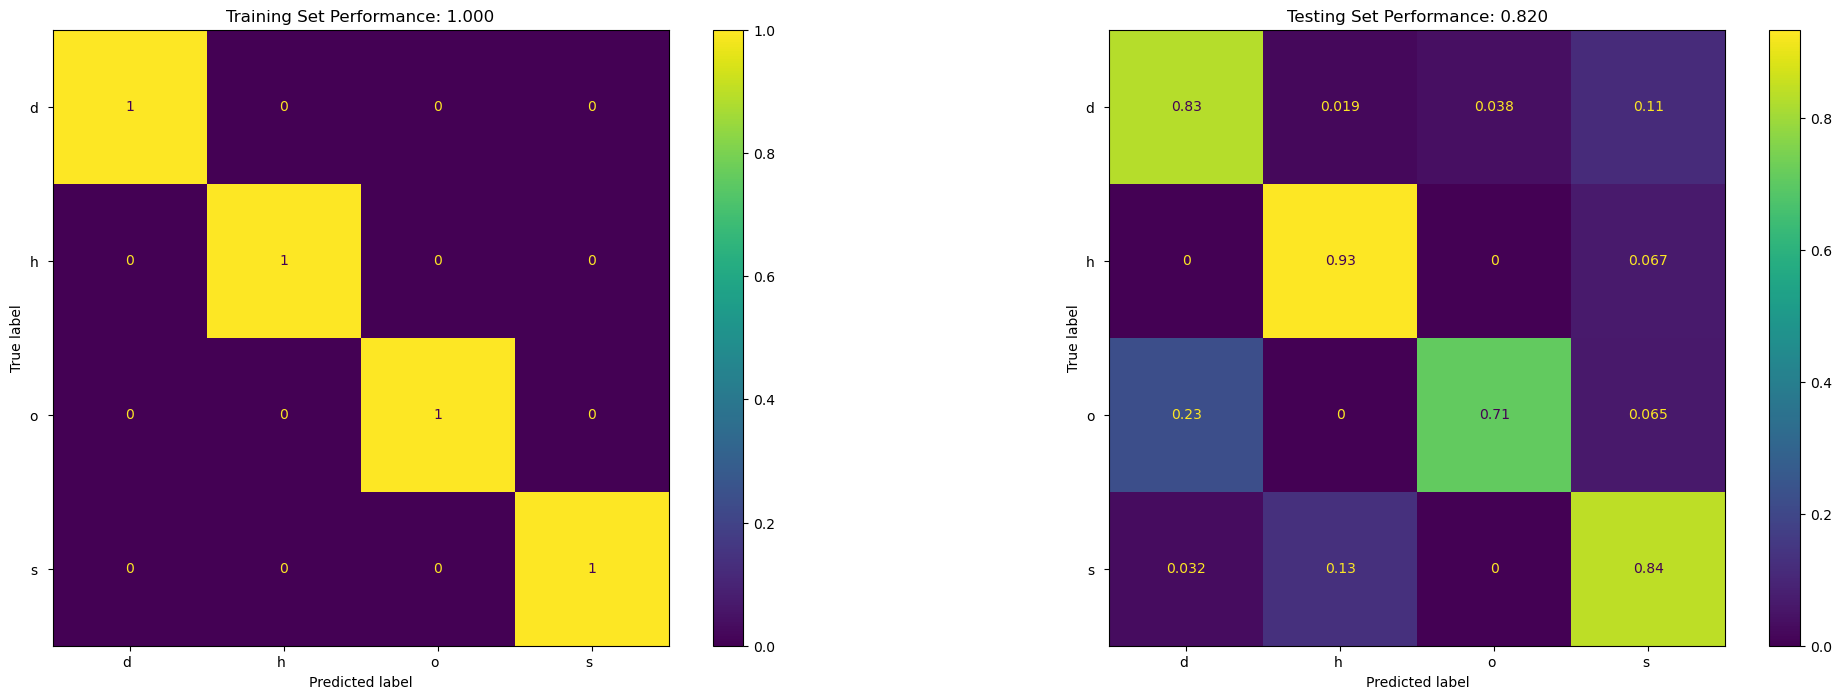

In [119]:
param_grid = {
    'n_neighbors': [1,2,3,4,5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn = GridSearchCV(
    estimator=cknn,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn, X_train, Y_train, X_test, Y_test)

# CKNN MODEL FINAL

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}
              precision    recall  f1-score   support

          d        0.80      0.74      0.76        53
          h        0.58      0.93      0.72        15
          o        0.95      0.61      0.75        31
          s        0.78      0.85      0.82        62

    accuracy                           0.78       161
   macro avg       0.78      0.78      0.76       161
weighted avg       0.80      0.78      0.78       161



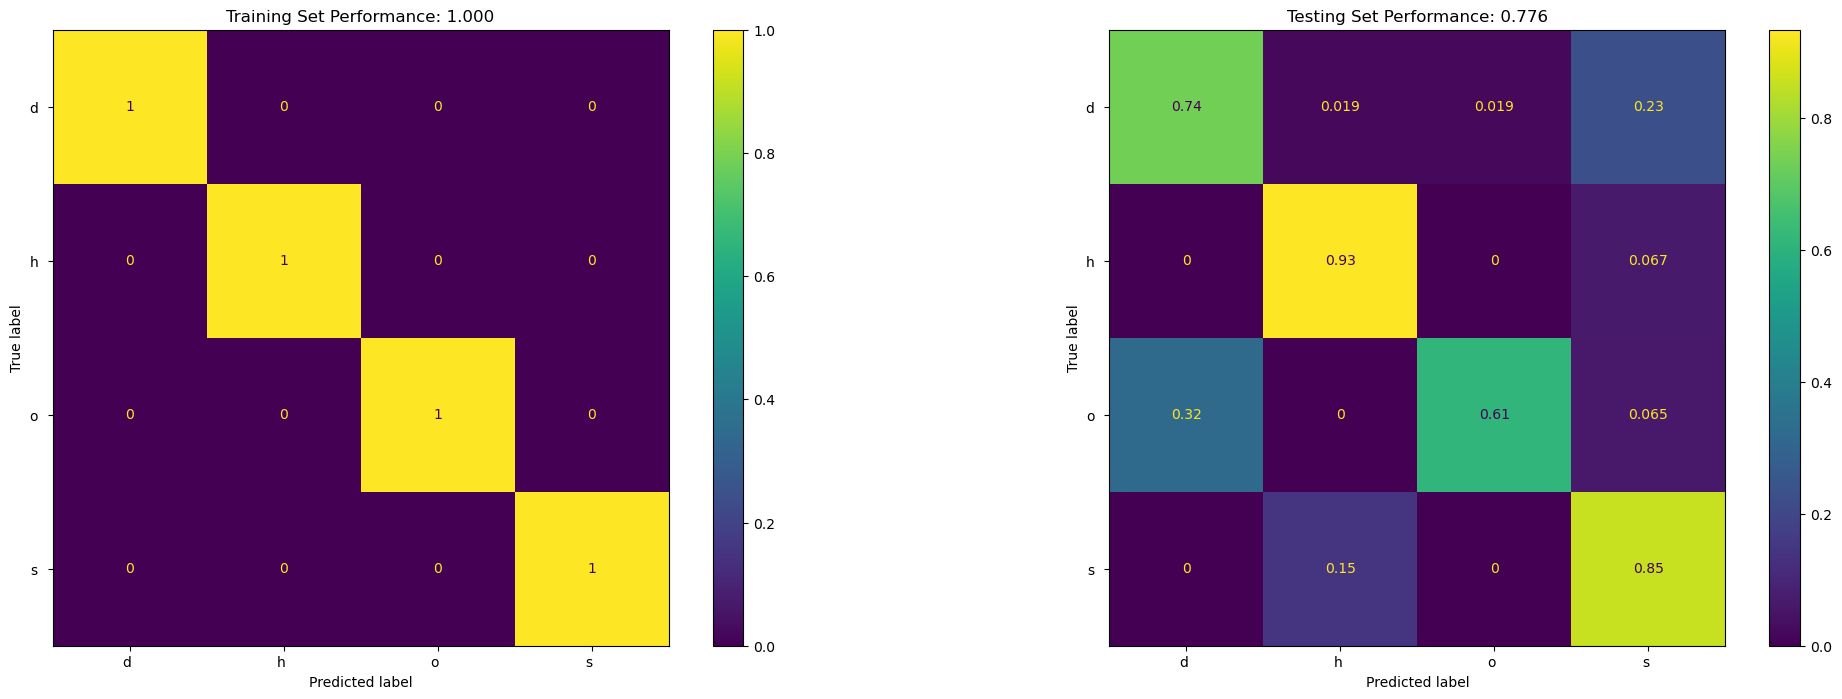

In [31]:
param_grid = {
    'n_neighbors': [15,16,17,18,19,20,21,22,23,24,25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn = GridSearchCV(
    estimator=cknn,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn, X_train, Y_train, X_test, Y_test)

# CKNN With Standardized Data

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

          d        0.83      0.83      0.83        53
          h        0.61      0.93      0.74        15
          o        0.92      0.71      0.80        31
          s        0.85      0.84      0.85        62

    accuracy                           0.82       161
   macro avg       0.80      0.83      0.80       161
weighted avg       0.83      0.82      0.82       161



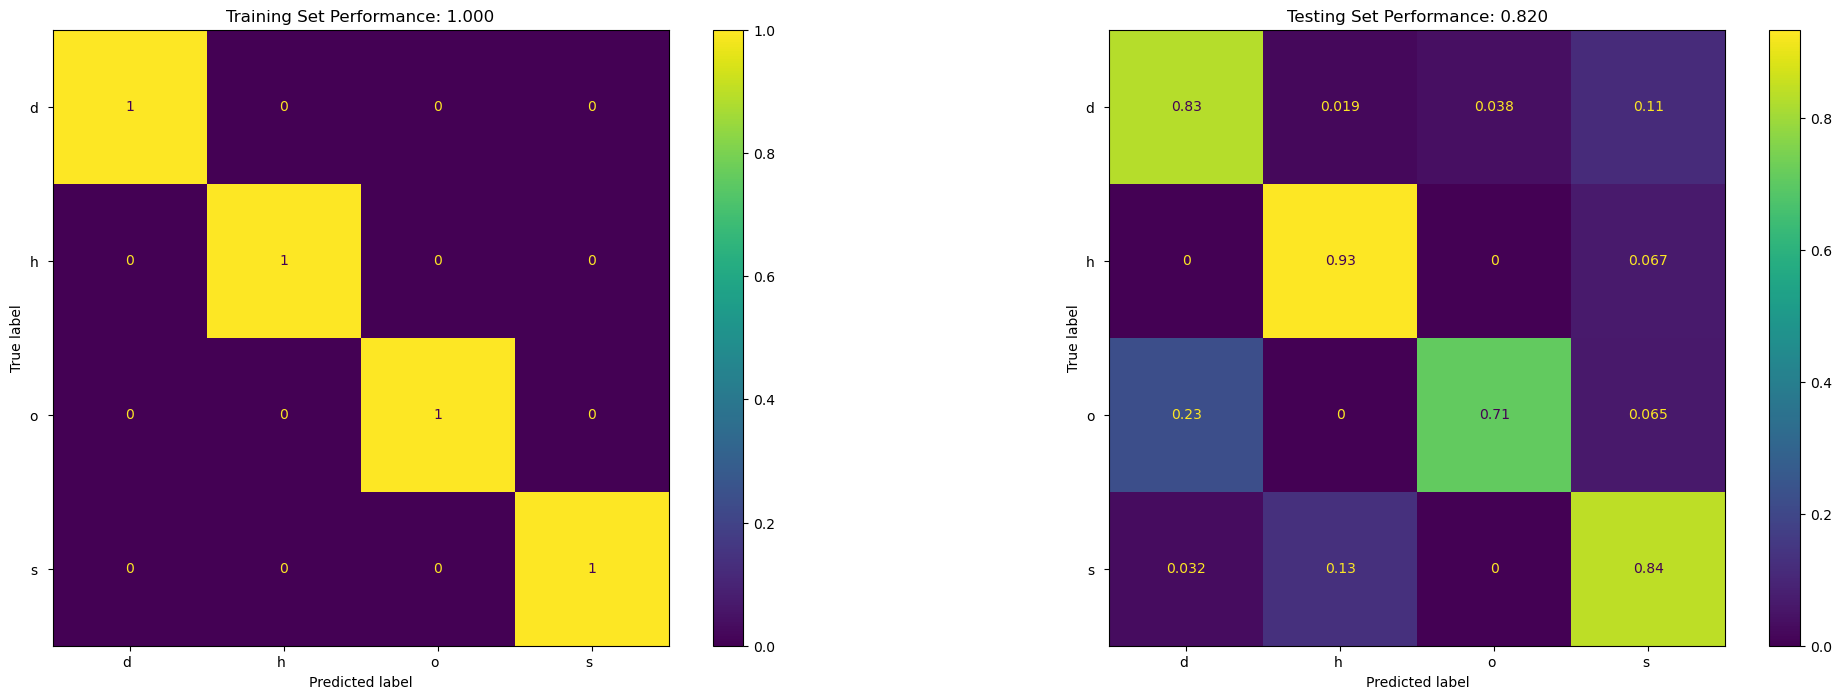

In [28]:
param_grid = {
    'n_neighbors': [1,5,10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn_std = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn_std = GridSearchCV(
    estimator=cknn_std,
    param_grid=param_grid,
    cv=train_val_split_std,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn_std, X_train_std, Y_train, X_test_std, Y_test)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

          d        0.83      0.81      0.82        53
          h        0.64      0.93      0.76        15
          o        0.95      0.68      0.79        31
          s        0.83      0.87      0.85        62

    accuracy                           0.82       161
   macro avg       0.81      0.82      0.80       161
weighted avg       0.84      0.82      0.82       161



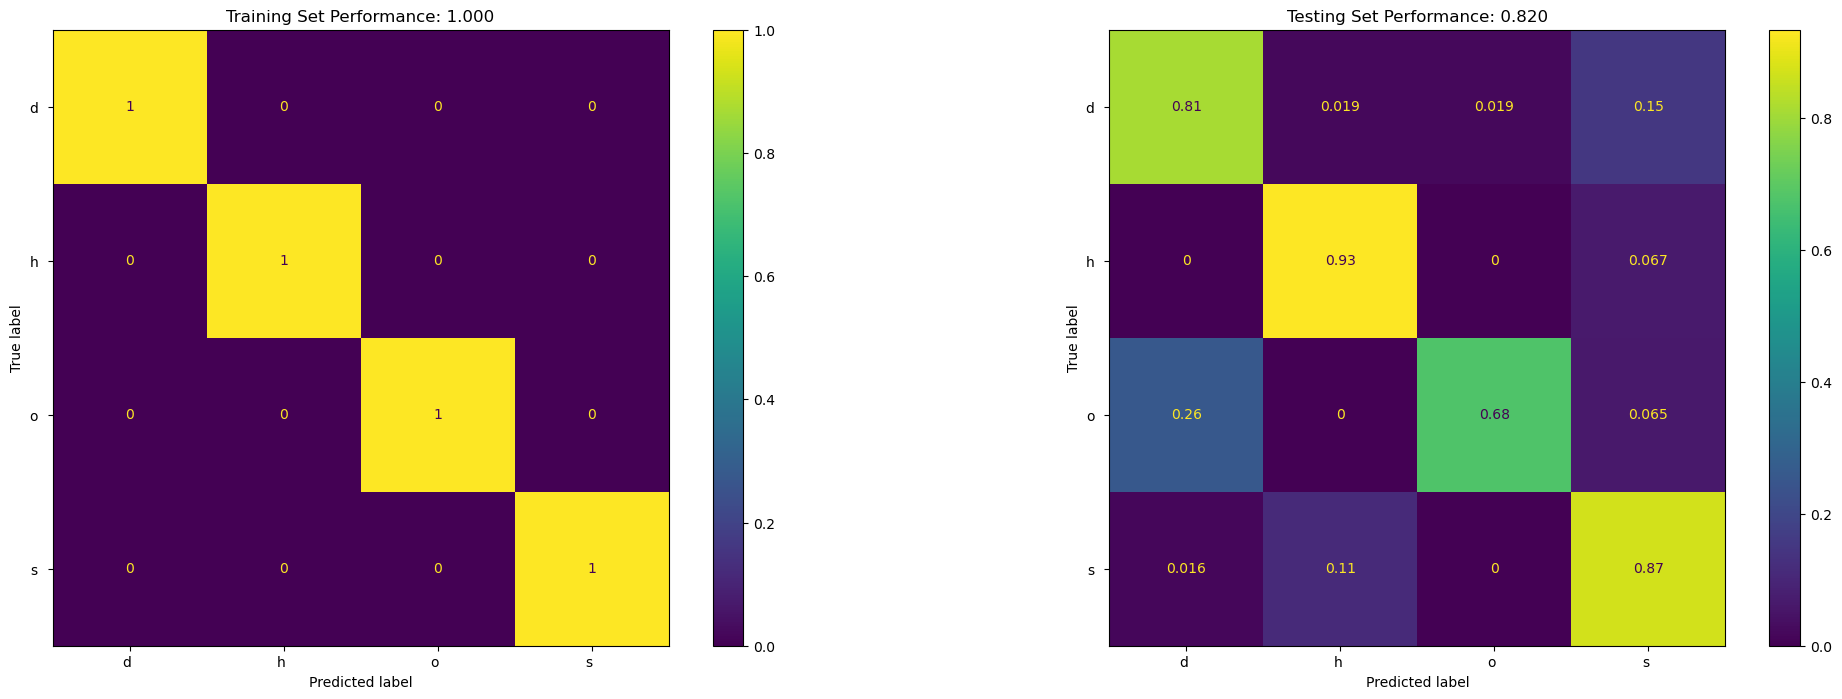

In [37]:
# Normalised Data
param_grid = {
    'n_neighbors': [1,5,10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn_norm = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn_norm = GridSearchCV(
    estimator=cknn_norm,
    param_grid=param_grid,
    cv=train_val_split_norm,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn_norm.fit(X_train_and_val_norm, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn_norm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn_norm, X_train_norm, Y_train, X_test_norm, Y_test)

# Refining Standardised CKNN
Although results show pretty much same performance. We are going to use the standardised data. As this is generally best practice for this type of model
From what we can see, with a n neighrbour range of 1,5, 10, we get the best at 1, so we will refine our search from 1 to 4 1 at a time

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

          d        0.83      0.83      0.83        53
          h        0.61      0.93      0.74        15
          o        0.92      0.71      0.80        31
          s        0.85      0.84      0.85        62

    accuracy                           0.82       161
   macro avg       0.80      0.83      0.80       161
weighted avg       0.83      0.82      0.82       161



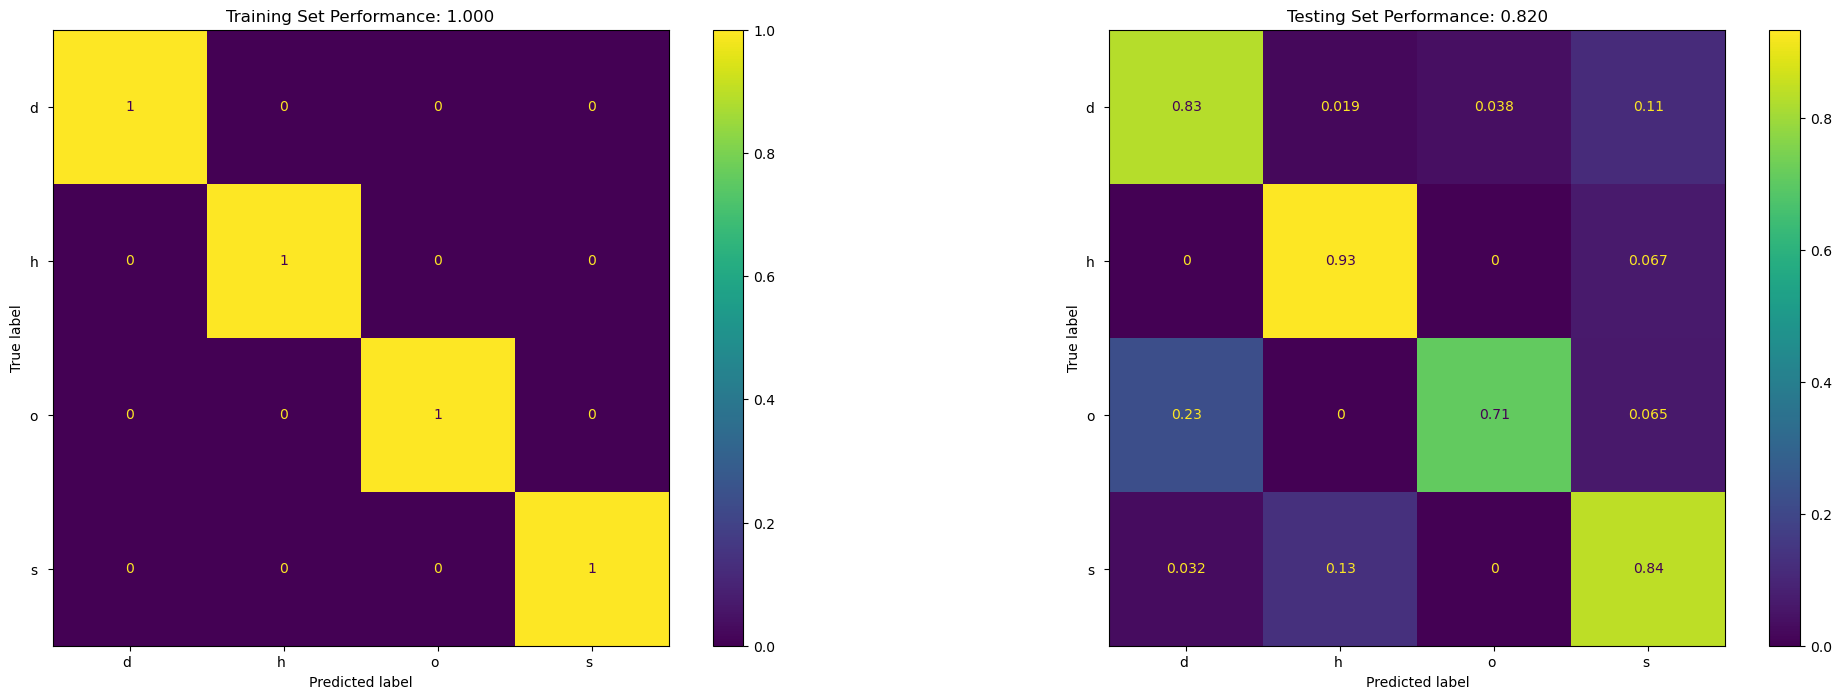

In [21]:
param_grid = {
    'n_neighbors': [1,2,3,4],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Set up the grid search
cknn_std = KNeighborsClassifier()  # We'll let GridSearchCV try different params
grid_search_cknn_std = GridSearchCV(
    estimator=cknn_std,
    param_grid=param_grid,
    cv=train_val_split_std,   # Use our PredefinedSplit for train vs. val
    scoring='accuracy',   # Or another scoring function if you prefer
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_cknn_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_cknn_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_cknn_std, X_train_std, Y_train, X_test_std, Y_test)

Our Best Neighbour is still 1, deducing that these parameters are the best the model is gonna give. 

# SVM Model - Non Standardised Data OVO

Best parameters found: {'C': 100, 'degree': 3, 'kernel': 'poly'}
              precision    recall  f1-score   support

          d        0.88      0.92      0.90        53
          h        0.70      0.93      0.80        15
          o        0.96      0.81      0.88        31
          s        0.93      0.89      0.91        62

    accuracy                           0.89       161
   macro avg       0.87      0.89      0.87       161
weighted avg       0.90      0.89      0.89       161

              precision    recall  f1-score   support

          d        0.88      0.92      0.90        53
          h        0.70      0.93      0.80        15
          o        0.96      0.81      0.88        31
          s        0.93      0.89      0.91        62

    accuracy                           0.89       161
   macro avg       0.87      0.89      0.87       161
weighted avg       0.90      0.89      0.89       161



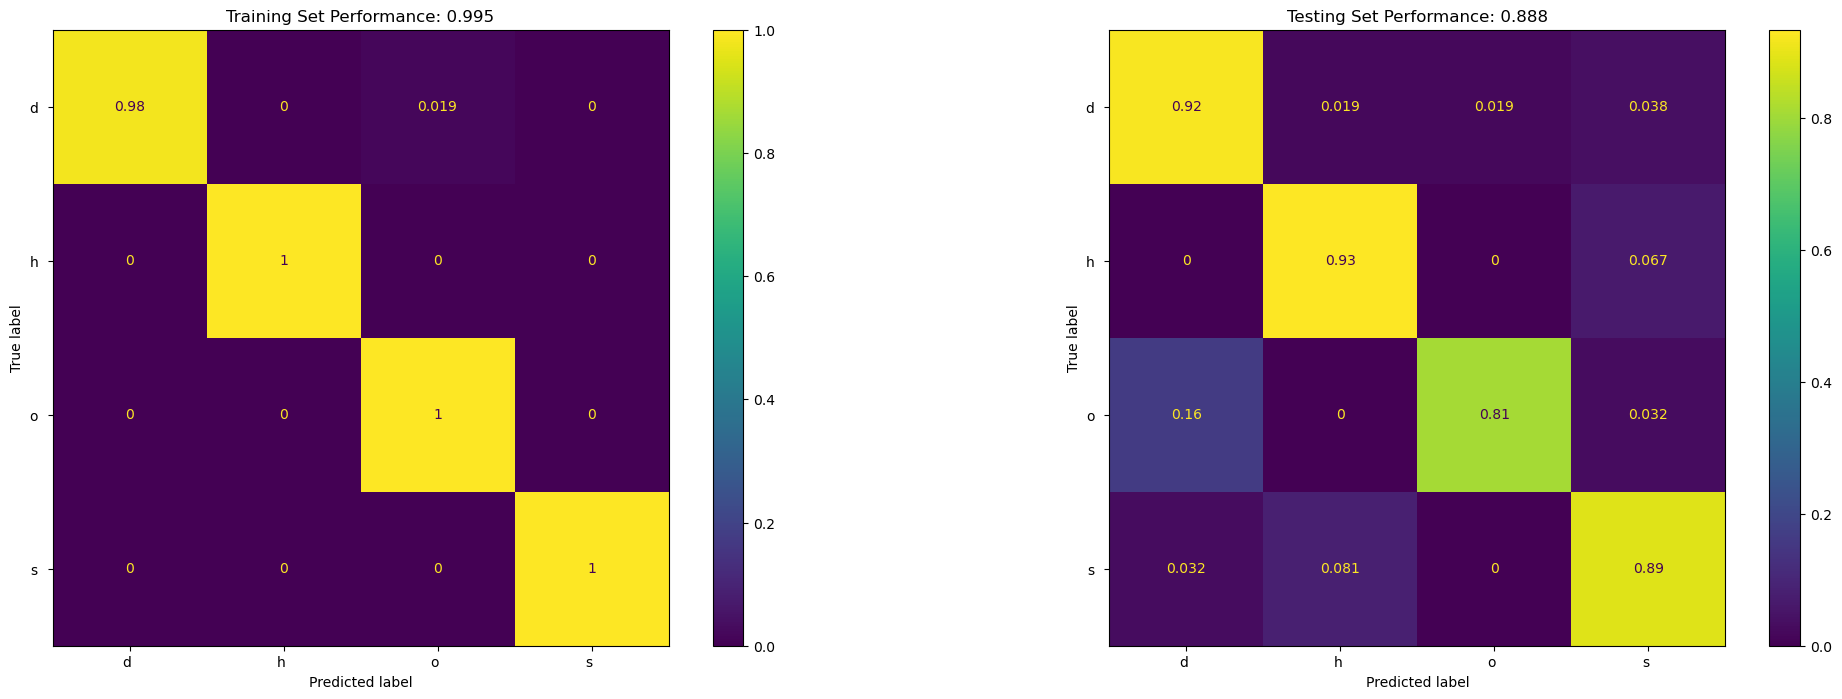

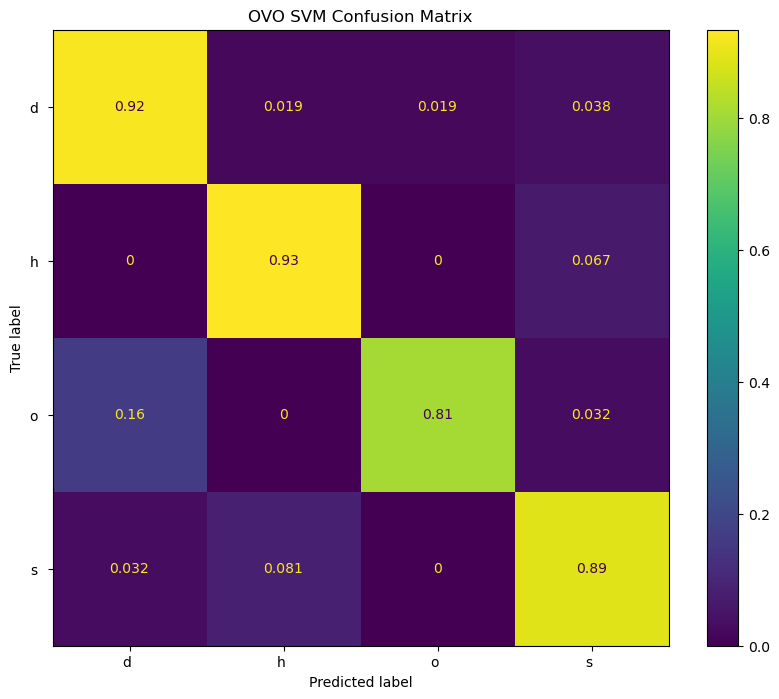

In [32]:
# Train your SVM. You should consider the following parameters at least:
#  - C
#  - Kernel Type
#  - Kernel Parameters
#  - Ensemble scheme (i.e. "one vs one" or "one vs all")
# Please note, you'd don't need to find the "perfect" parameters. The grid search does not need to consider every possible value,
# and can be quite coarse to avoid long run-times. You may also wish to conduct a rough search first, and then a refined search, 
# though this is not required.

param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm = SVC(class_weight='balanced')

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm, X_train, Y_train, X_test, Y_test)
test = eval_model_TEST(grid_search_svm, X_train, Y_train, X_test, Y_test, "OVO SVM Confusion Matrix")

# Tweaking Params and seeing what values do what

Best parameters found: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

          d        0.88      0.83      0.85        53
          h        0.56      0.93      0.70        15
          o        0.96      0.81      0.88        31
          s        0.85      0.82      0.84        62

    accuracy                           0.83       161
   macro avg       0.81      0.85      0.82       161
weighted avg       0.85      0.83      0.84       161

Best parameters found: {'C': 100, 'degree': 3, 'kernel': 'poly'}
              precision    recall  f1-score   support

          d        0.88      0.92      0.90        53
          h        0.70      0.93      0.80        15
          o        0.96      0.81      0.88        31
          s        0.93      0.89      0.91        62

    accuracy                           0.89       161
   macro avg       0.87      0.89      0.87       161
weighted avg       0.90      0.89      0.89       161



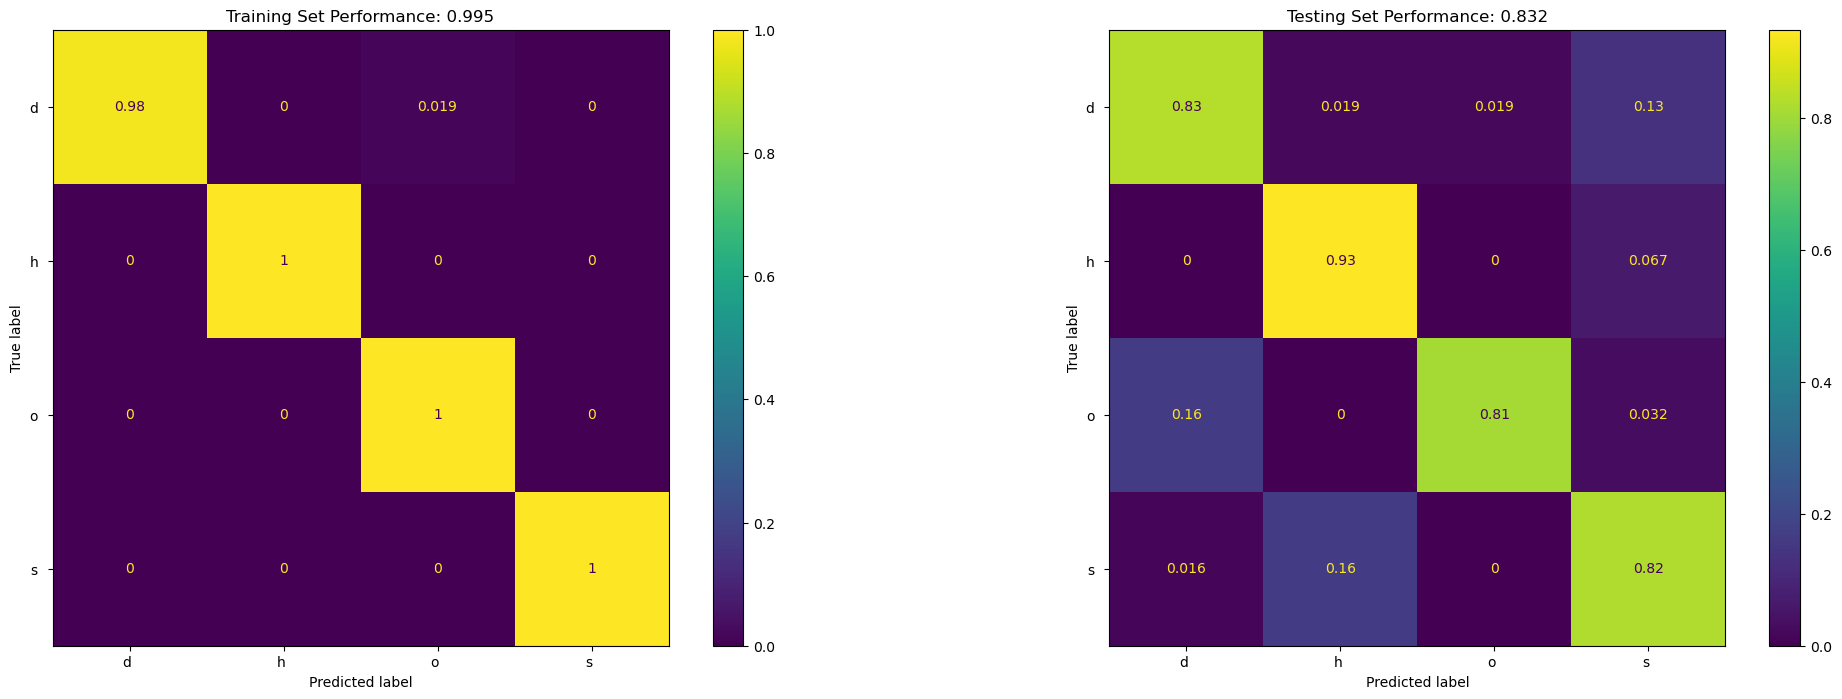

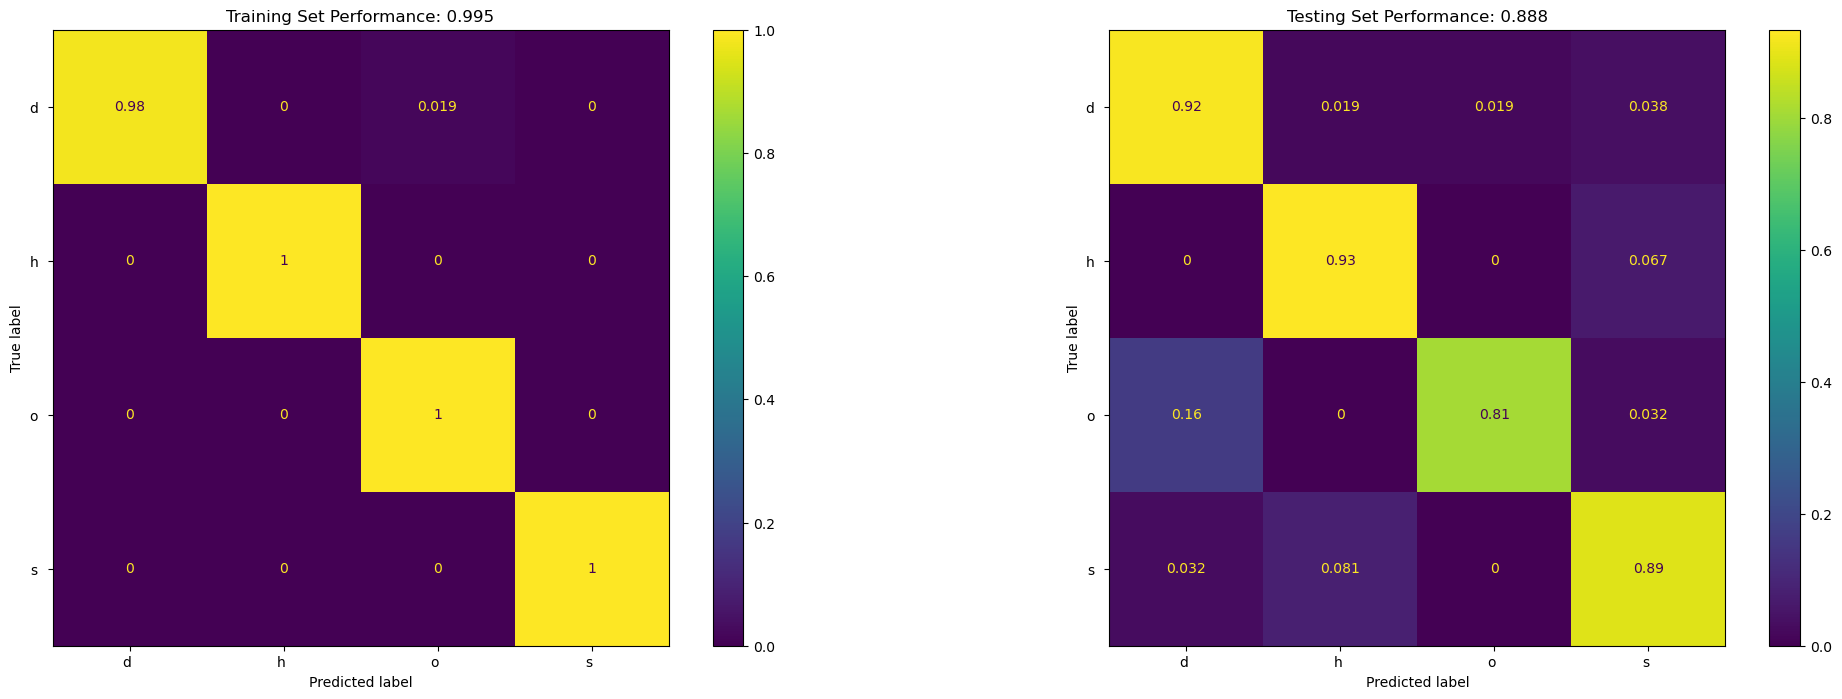

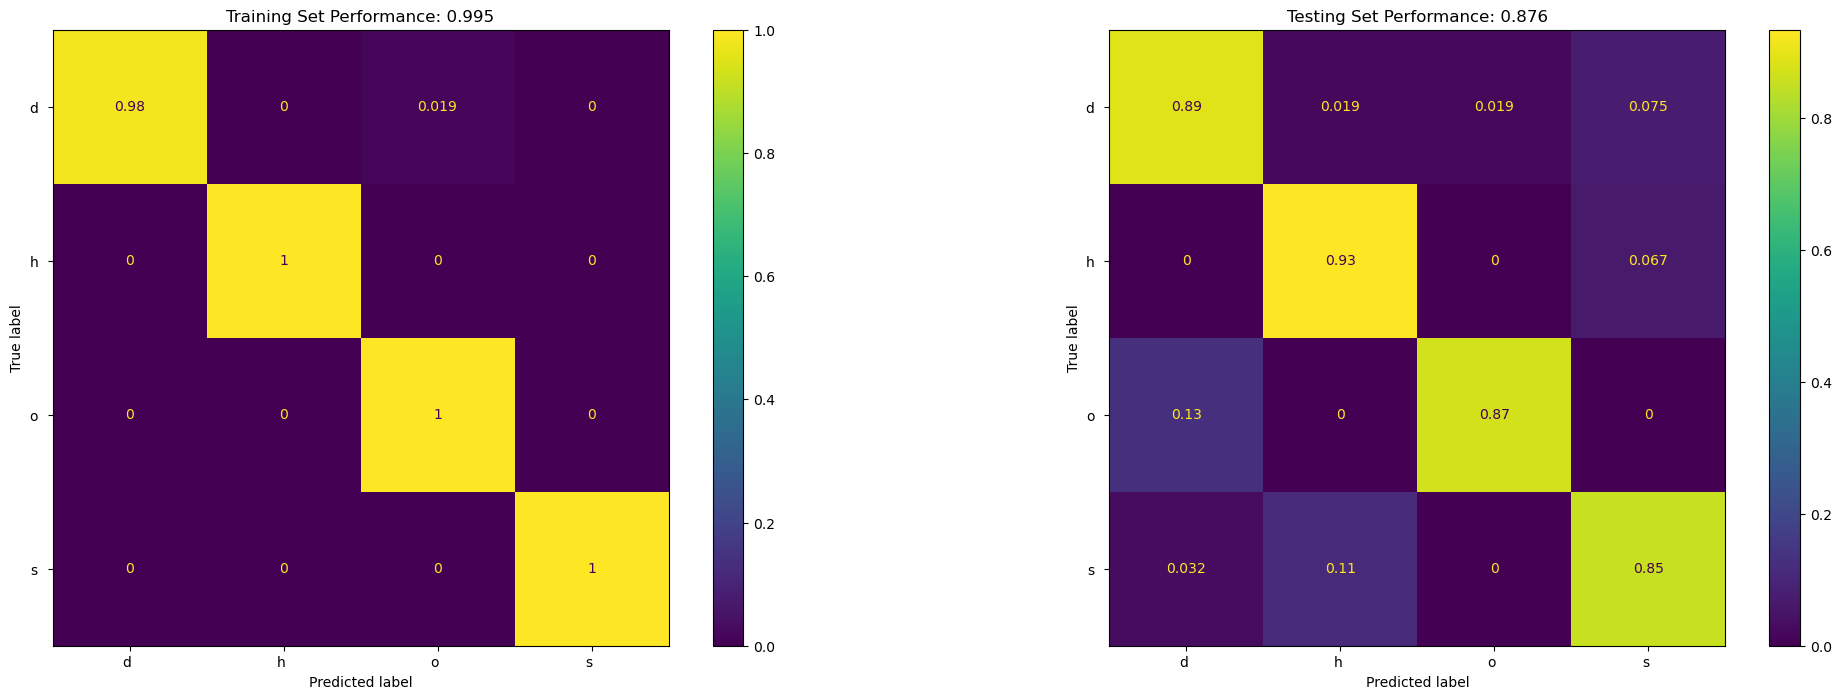

In [86]:
param_grid = [
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
 ]
svm = SVC(class_weight='balanced')

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm, X_train, Y_train, X_test, Y_test)

# POLY
param_grid = [
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm = SVC(class_weight='balanced')

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm, X_train, Y_train, X_test, Y_test)

# LINEAR
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
 ]
svm = SVC(class_weight='balanced')

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm, X_train, Y_train, X_test, Y_test)

# With Standardised Data SVM

Best parameters found: {'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.85      0.87        53
          h        0.64      0.93      0.76        15
          o        0.93      0.84      0.88        31
          s        0.88      0.85      0.87        62

    accuracy                           0.86       161
   macro avg       0.83      0.87      0.84       161
weighted avg       0.87      0.86      0.86       161



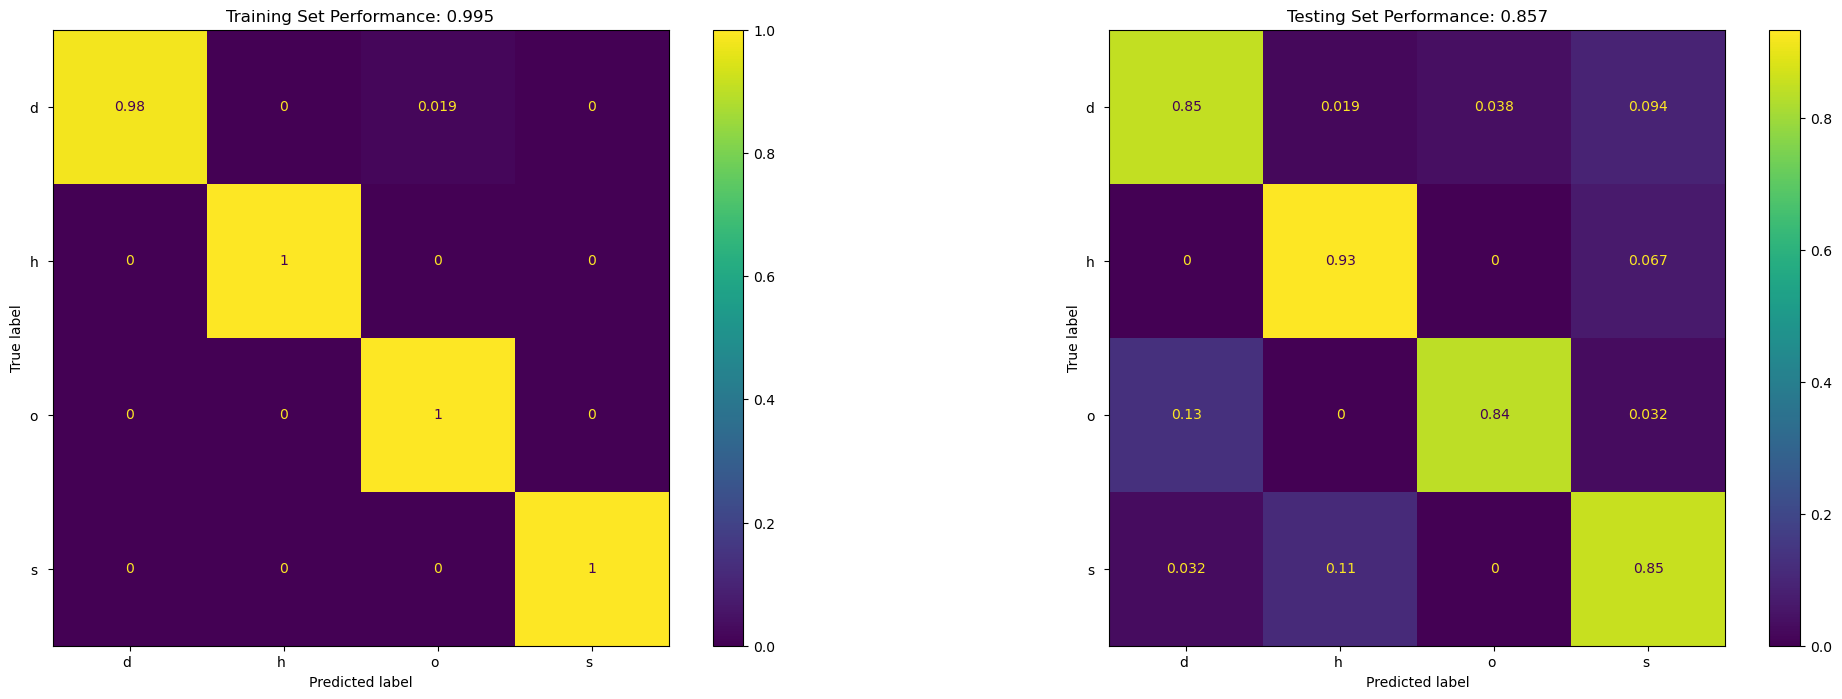

In [65]:
param_grid = [
  {'C': [0.1, 1, 10,100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5,6,7], 'kernel': ['poly']},
 ]
svm_std = SVC(class_weight='balanced')

grid_search_svm_std = GridSearchCV(estimator=svm_std, param_grid=param_grid, cv=train_val_split_std, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_std, X_train_std, Y_train, X_test_std, Y_test)

Best parameters found: {'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.83      0.85        53
          h        0.58      0.93      0.72        15
          o        0.89      0.81      0.85        31
          s        0.88      0.84      0.86        62

    accuracy                           0.84       161
   macro avg       0.81      0.85      0.82       161
weighted avg       0.86      0.84      0.84       161



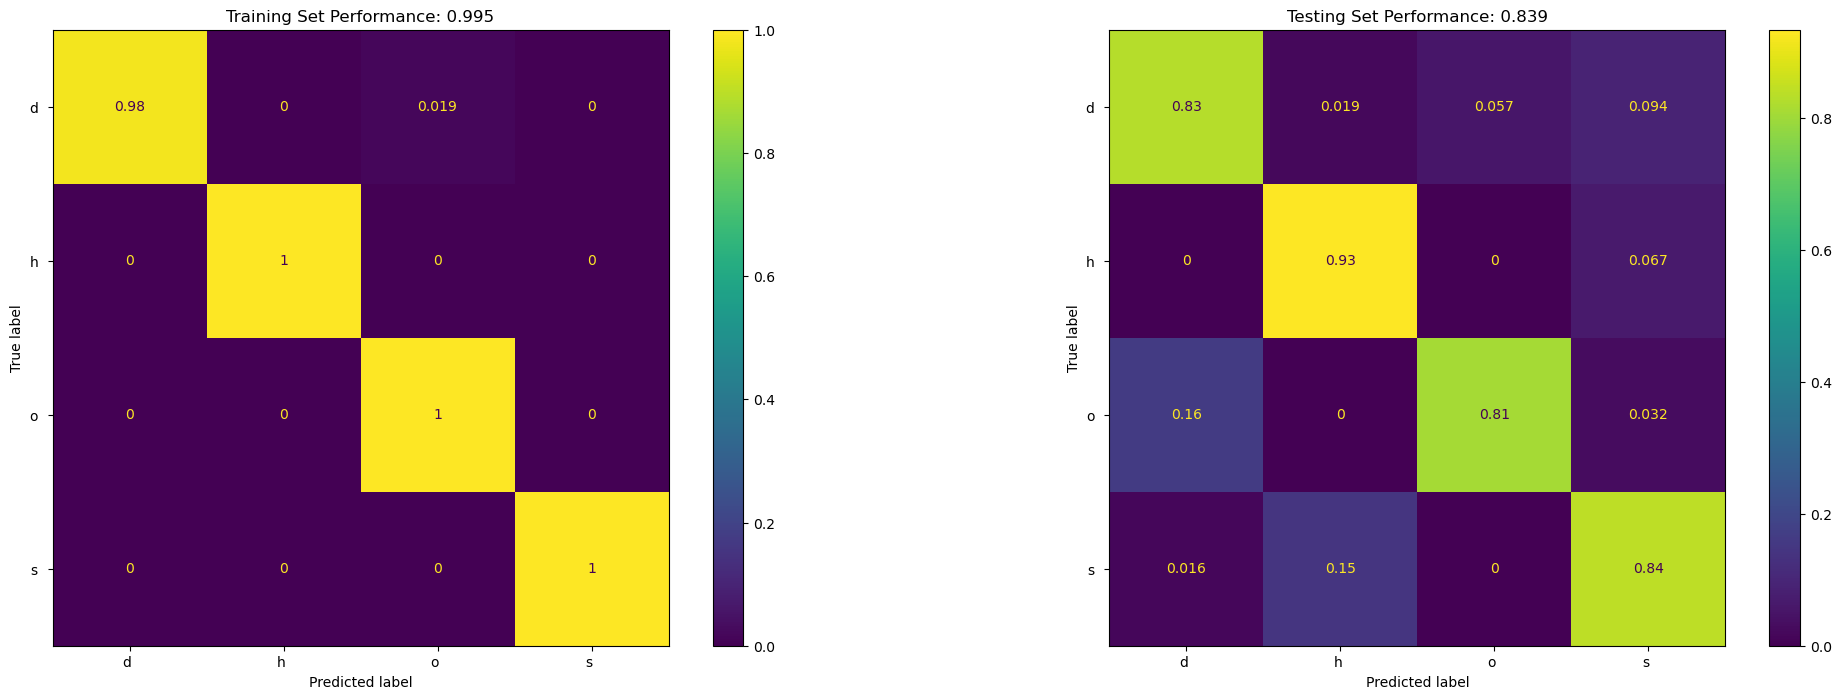

In [39]:
# Normalised
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm_norm = SVC(class_weight='balanced')

grid_search_svm_norm = GridSearchCV(estimator=svm_norm, param_grid=param_grid, cv=train_val_split_norm, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm_norm.fit(X_train_and_val_norm, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_norm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_norm, X_train_norm, Y_train, X_test_norm, Y_test)

# Refining  One vs One Std

Best parameters found: {'C': 15, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.85      0.87        53
          h        0.67      0.93      0.78        15
          o        0.90      0.84      0.87        31
          s        0.90      0.87      0.89        62

    accuracy                           0.86       161
   macro avg       0.84      0.87      0.85       161
weighted avg       0.87      0.86      0.87       161



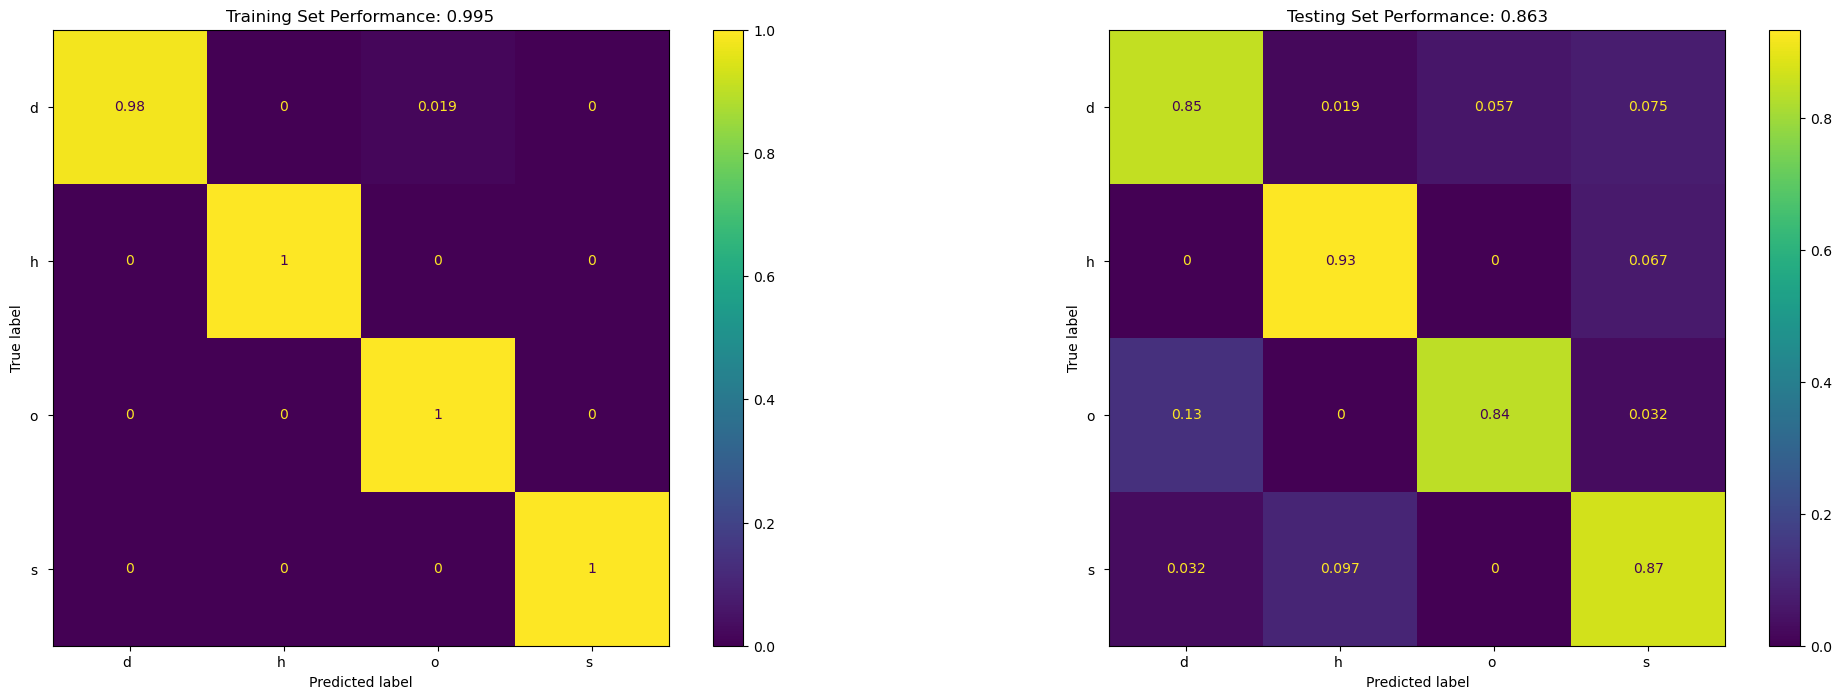

In [13]:
# Thought Process, since we are getting best values at C of 10, we should expand our solution to reduce down from 100
#
param_grid = [
  {'C': [10,15,20,50], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm_std = SVC(class_weight='balanced')

grid_search_svm_std = GridSearchCV(estimator=svm_std, param_grid=param_grid, cv=train_val_split_std, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_std, X_train_std, Y_train, X_test_std, Y_test)

Best parameters found: {'C': 15, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.85      0.87        53
          h        0.67      0.93      0.78        15
          o        0.90      0.84      0.87        31
          s        0.90      0.87      0.89        62

    accuracy                           0.86       161
   macro avg       0.84      0.87      0.85       161
weighted avg       0.87      0.86      0.87       161



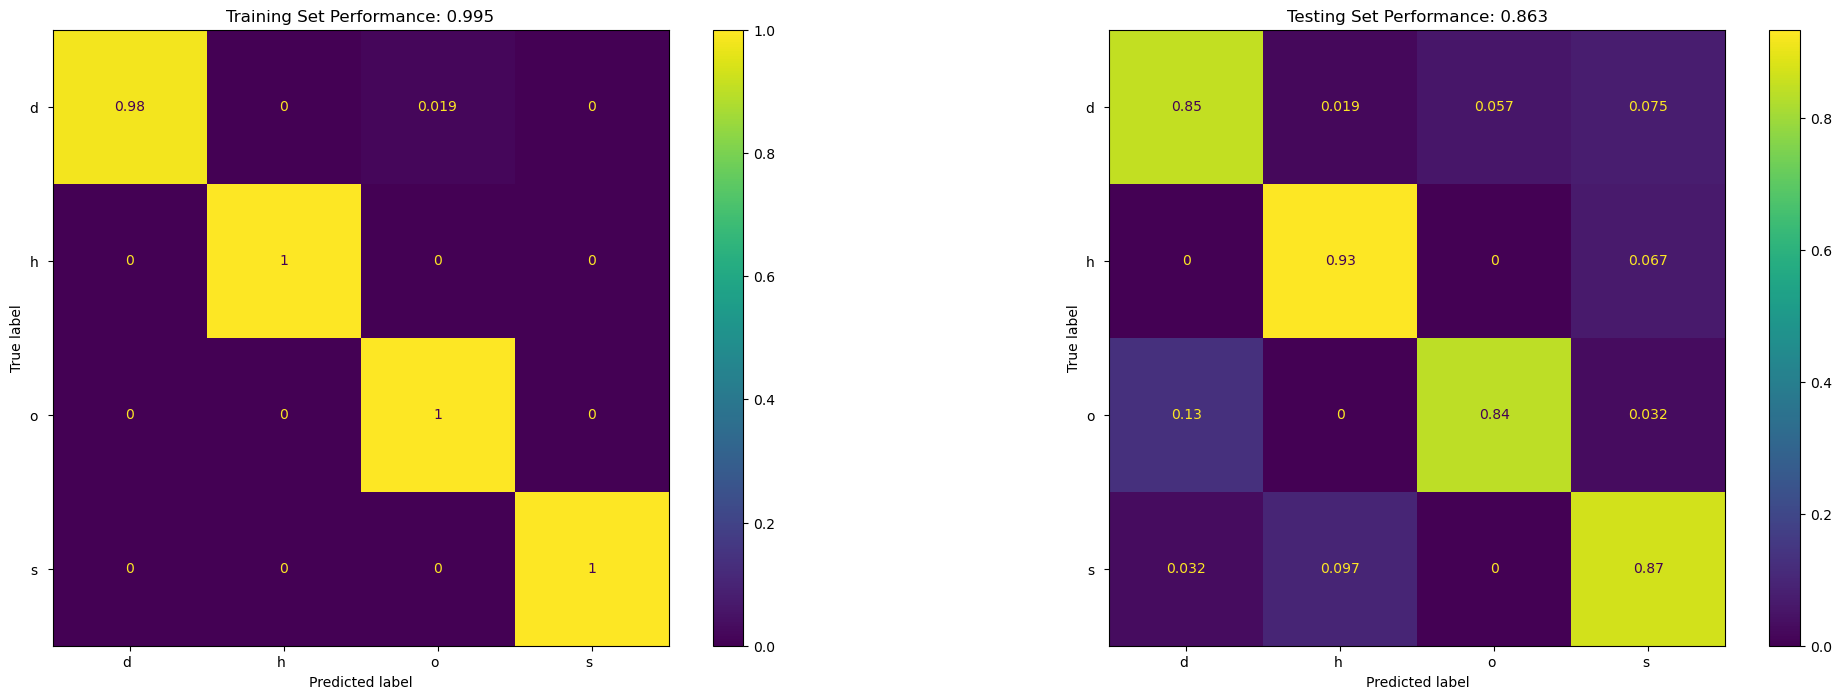

In [14]:
# Final Refining:
# Thought Process, since we are getting best values at C of 10, we should expand our solution to reduce down from 100
#
param_grid = [
  {'C': [15,16,17,18,19,20], 'kernel': ['linear']},
  {'C': [15,16,17,18,19,20], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [15,16,17,18,19,20], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm_std = SVC(class_weight='balanced')

grid_search_svm_std = GridSearchCV(estimator=svm_std, param_grid=param_grid, cv=train_val_split_std, scoring='accuracy', n_jobs=-1)


# Run the grid search on the combined dataset
grid_search_svm_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_std, X_train_std, Y_train, X_test_std, Y_test)

# Using One Vs Rest Model No Std

Best parameters found: {'estimator__C': 1, 'estimator__degree': 3, 'estimator__kernel': 'poly'}
              precision    recall  f1-score   support

          d        0.85      0.74      0.79        53
          h        0.58      0.93      0.72        15
          o        0.95      0.68      0.79        31
          s        0.77      0.85      0.81        62

    accuracy                           0.79       161
   macro avg       0.79      0.80      0.78       161
weighted avg       0.81      0.79      0.79       161



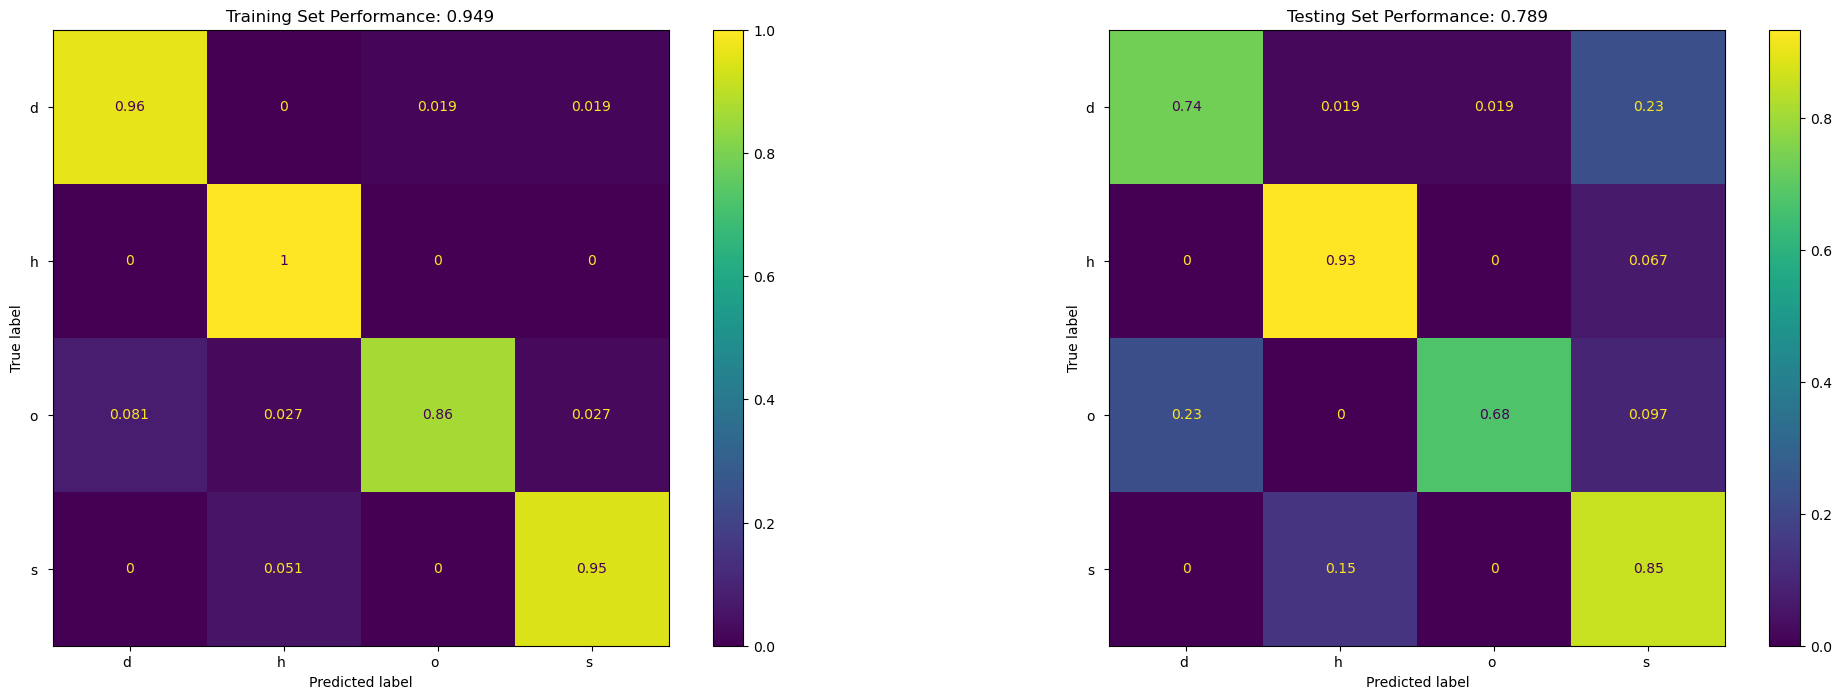

In [31]:
# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.1, 0.01, 0.001], 'estimator__kernel': ['rbf']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__degree': [3, 4, 5], 'estimator__kernel': ['poly']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR, X_train, Y_train, X_test, Y_test)

Best parameters found: {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.89      0.74      0.80        53
          h        0.65      1.00      0.79        15
          o        0.96      0.84      0.90        31
          s        0.81      0.87      0.84        62

    accuracy                           0.83       161
   macro avg       0.83      0.86      0.83       161
weighted avg       0.85      0.83      0.83       161

Best parameters found: {'estimator__C': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf'}
              precision    recall  f1-score   support

          d        0.88      0.87      0.88        53
          h        0.61      0.93      0.74        15
          o        0.96      0.81      0.88        31
          s        0.88      0.85      0.87        62

    accuracy                           0.86       161
   macro avg       0.83      0.87      0.84       161
weighted av

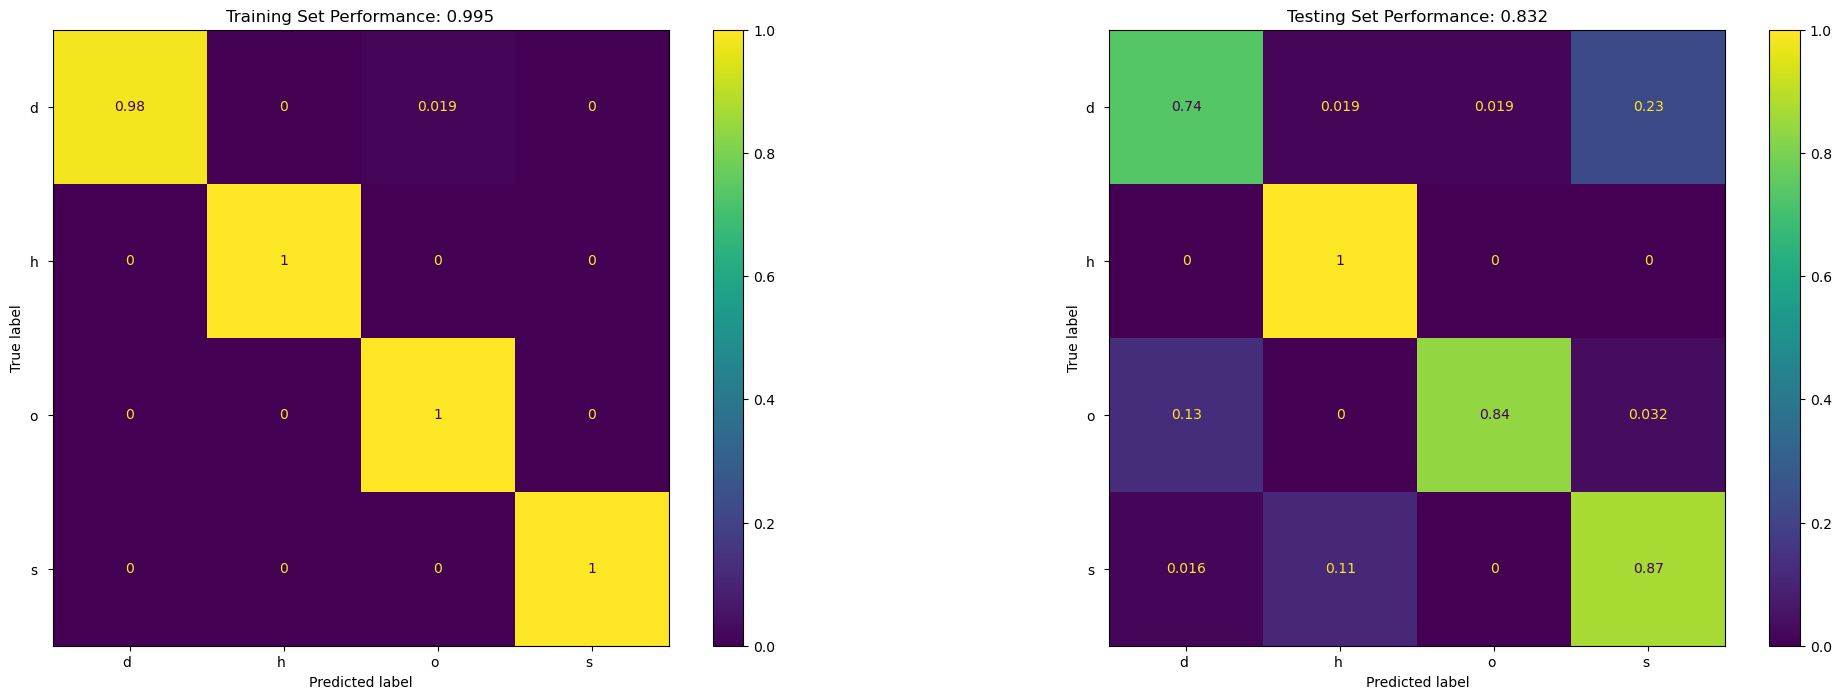

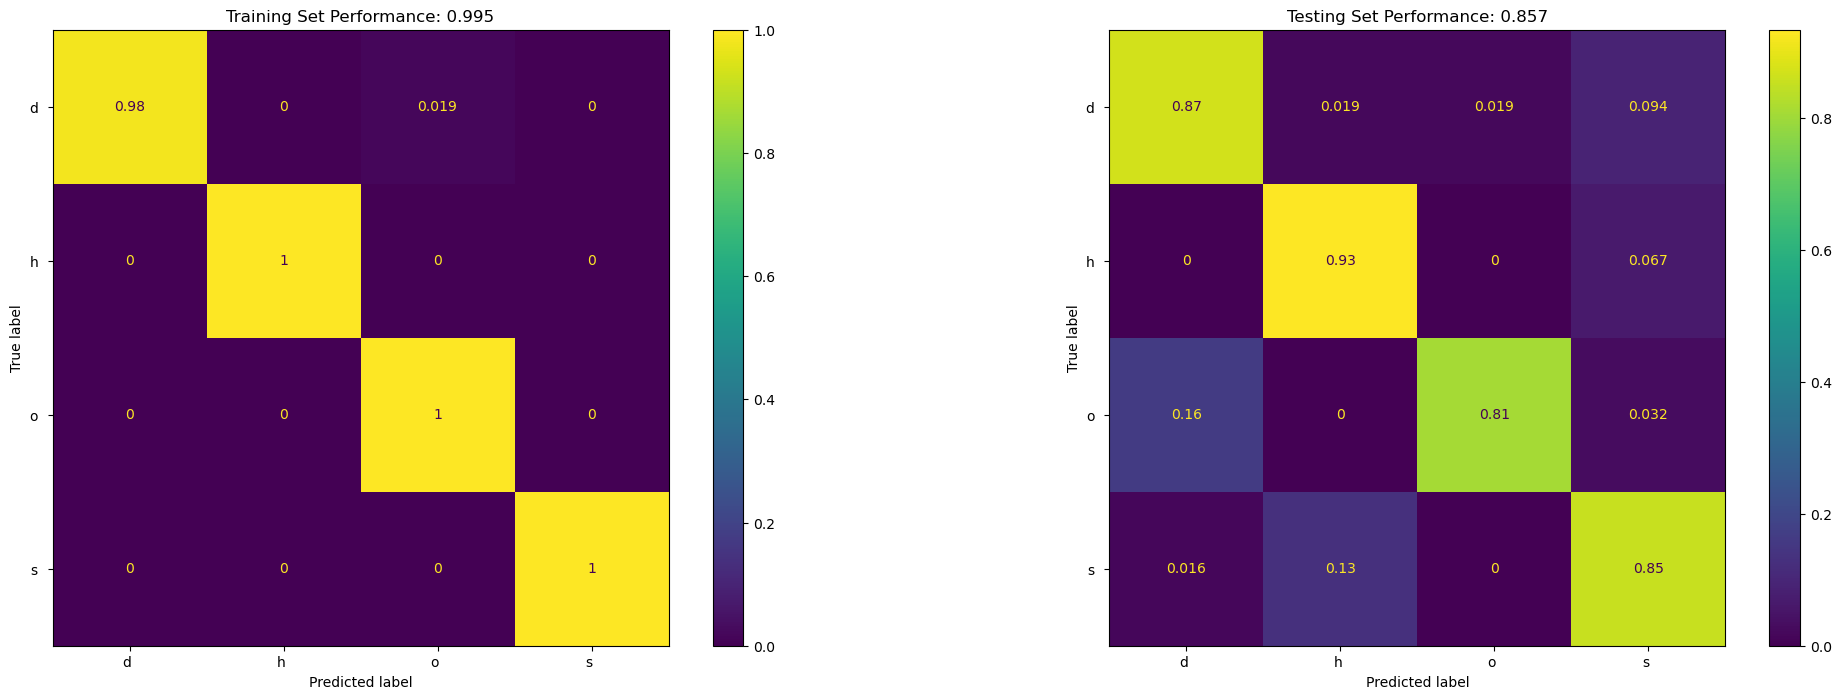

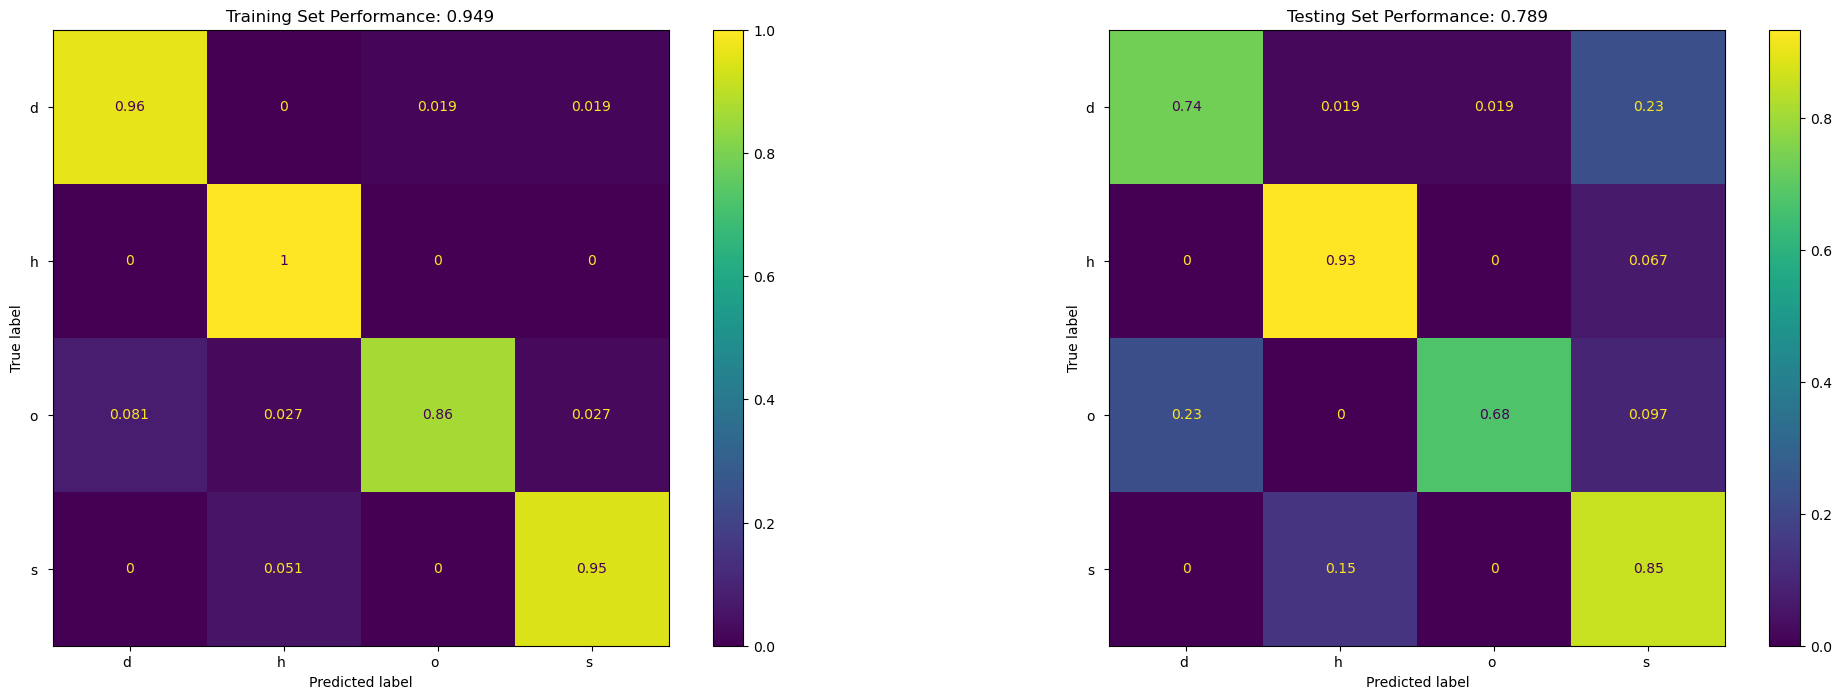

In [89]:
# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__kernel': ['linear']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR, X_train, Y_train, X_test, Y_test)

# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.1, 0.01, 0.001], 'estimator__kernel': ['rbf']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR, X_train, Y_train, X_test, Y_test)

# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__degree': [3, 4, 5], 'estimator__kernel': ['poly']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR, X_train, Y_train, X_test, Y_test)

# Using One Vs Rest Model w Std

Best parameters found: {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.85      0.74      0.79        53
          h        0.56      0.93      0.70        15
          o        1.00      0.65      0.78        31
          s        0.74      0.84      0.79        62

    accuracy                           0.78       161
   macro avg       0.79      0.79      0.77       161
weighted avg       0.81      0.78      0.78       161



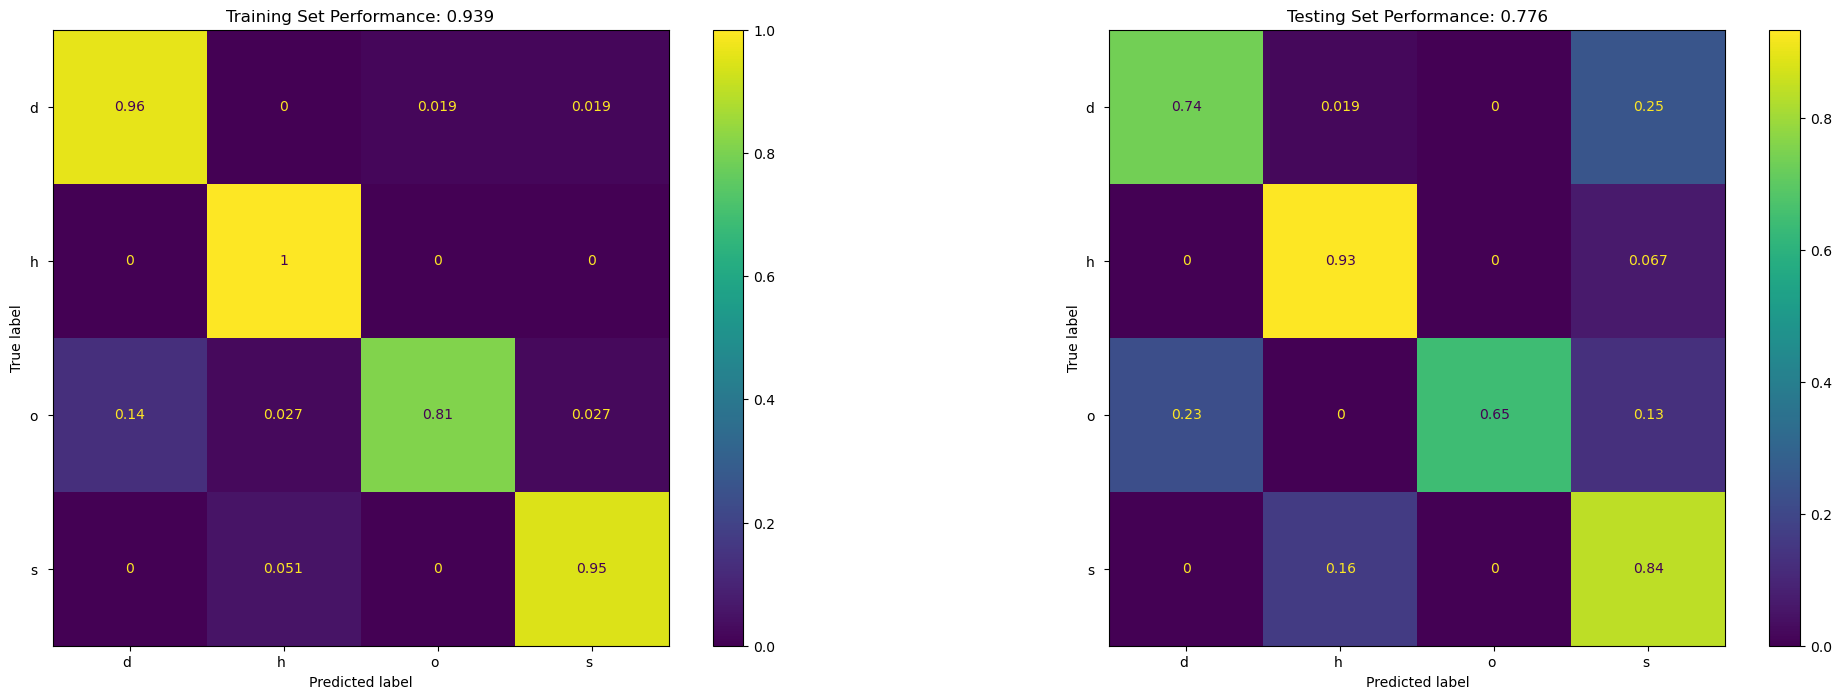

In [16]:
# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 15, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.1, 0.01, 0.001], 'estimator__kernel': ['rbf']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__degree': [3, 4, 5], 'estimator__kernel': ['poly']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR_std = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split_std, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR_std, X_train_std, Y_train, X_test_std, Y_test)

# Using One Vs Rest Normalised

Best parameters found: {'estimator__C': 100, 'estimator__kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.72      0.79        53
          h        0.65      1.00      0.79        15
          o        0.93      0.81      0.86        31
          s        0.79      0.87      0.83        62

    accuracy                           0.82       161
   macro avg       0.81      0.85      0.82       161
weighted avg       0.84      0.82      0.82       161



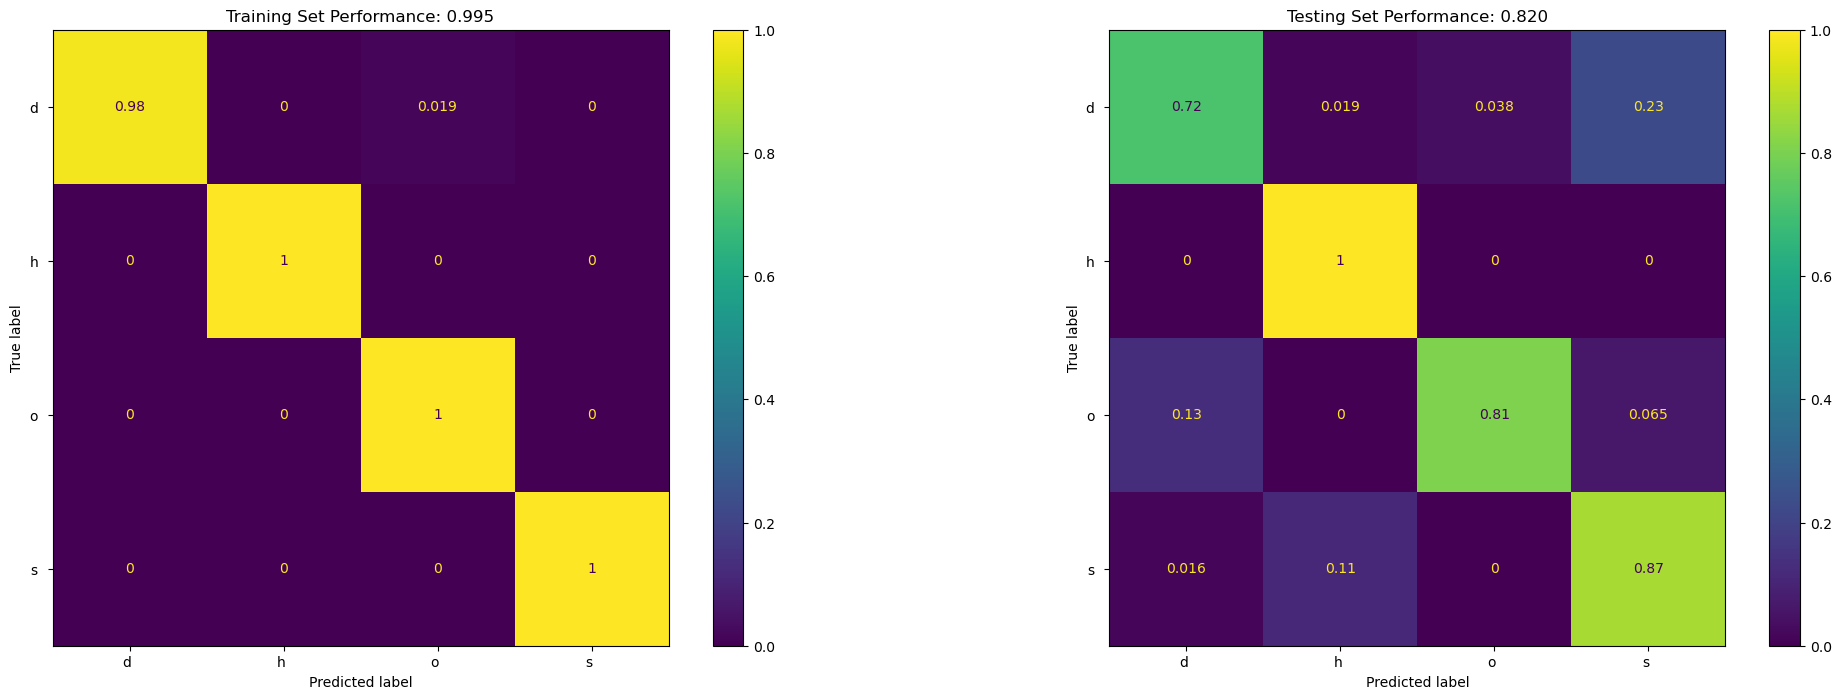

In [42]:
# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 1, 10, 15, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__gamma': [0.1, 0.01, 0.001], 'estimator__kernel': ['rbf']},
  {'estimator__C': [0.1, 1, 10, 100], 'estimator__degree': [3, 4, 5], 'estimator__kernel': ['poly']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR_norm = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split_norm, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR_norm.fit(X_train_and_val_norm, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR_norm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR_norm, X_train_norm, Y_train, X_test_norm, Y_test)

# Using One Vs Rest Model w Std, Refining

Best parameters found: {'estimator__C': 0.1, 'estimator__kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.85      0.74      0.79        53
          h        0.56      0.93      0.70        15
          o        1.00      0.65      0.78        31
          s        0.74      0.84      0.79        62

    accuracy                           0.78       161
   macro avg       0.79      0.79      0.77       161
weighted avg       0.81      0.78      0.78       161



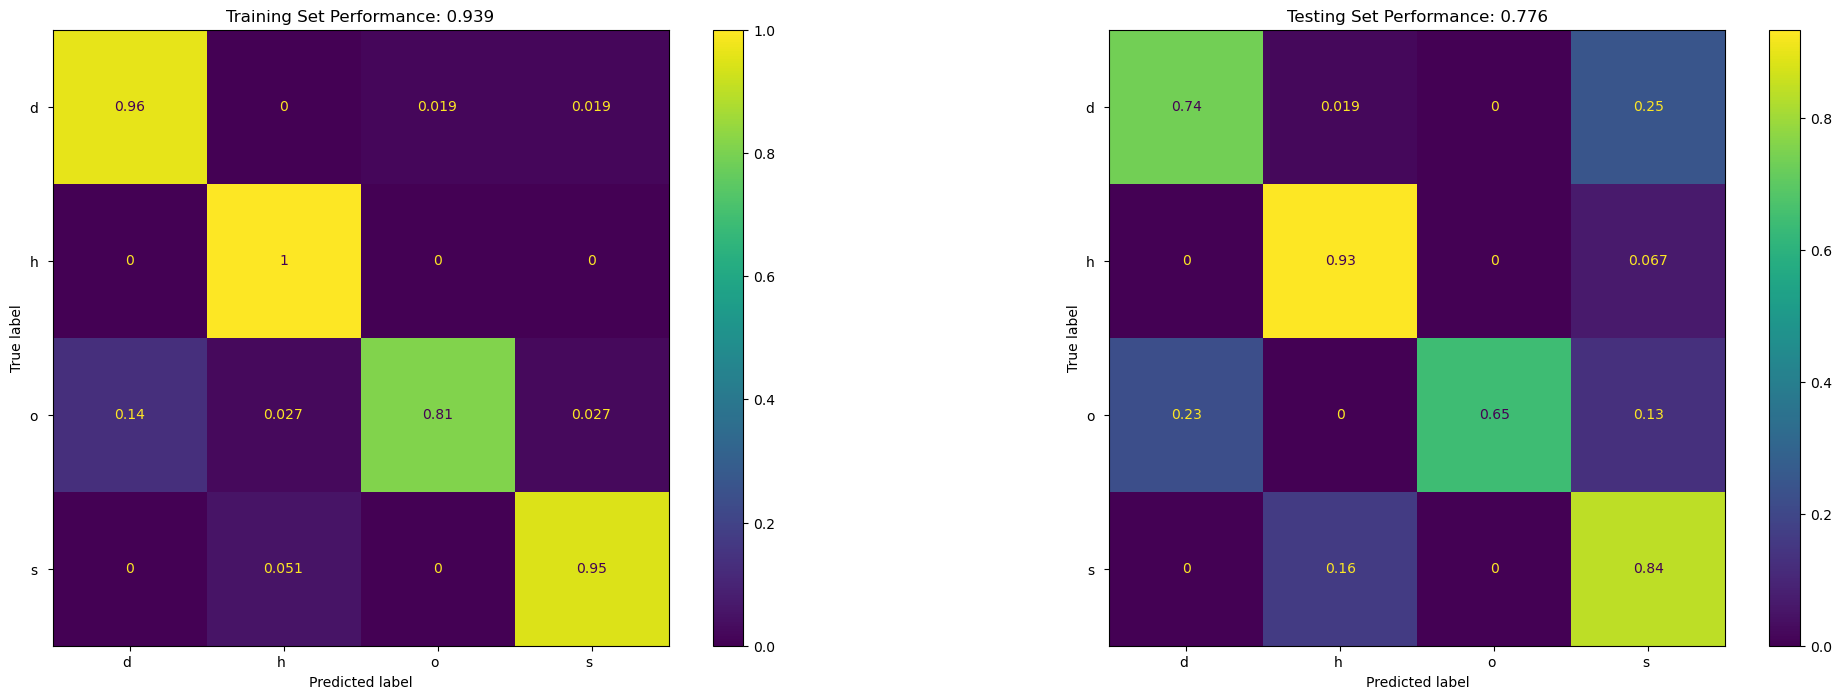

In [17]:
# The parameter grid: now each SVC parameter is prefixed with "estimator__"
param_grid = [
  {'estimator__C': [0.1, 0.2, 0.5], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.1, 0.2, 0.5], 'estimator__gamma': [0.1, 0.01, 0.001], 'estimator__kernel': ['rbf']},
  {'estimator__C': [0.1, 0.2, 0.5], 'estimator__degree': [3, 4, 5], 'estimator__kernel': ['poly']},
]

# Wrap SVC with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(SVC(class_weight='balanced'))

# Grid Search
grid_search_svm_OVR_std = GridSearchCV(estimator=svm_ovr, param_grid=param_grid, cv=train_val_split_std, scoring='accuracy', n_jobs=-1)

# Run the grid search on the combined dataset
grid_search_svm_OVR_std.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_svm_OVR_std.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_svm_OVR_std, X_train_std, Y_train, X_test_std, Y_test)

# Random Forest

Best parameters found: {'max_depth': 5, 'n_estimators': 10}
              precision    recall  f1-score   support

          d        0.79      0.79      0.79        53
          h        0.70      0.93      0.80        15
          o        0.96      0.74      0.84        31
          s        0.84      0.87      0.86        62

    accuracy                           0.83       161
   macro avg       0.82      0.83      0.82       161
weighted avg       0.84      0.83      0.83       161

              precision    recall  f1-score   support

          d        0.79      0.79      0.79        53
          h        0.70      0.93      0.80        15
          o        0.96      0.74      0.84        31
          s        0.84      0.87      0.86        62

    accuracy                           0.83       161
   macro avg       0.82      0.83      0.82       161
weighted avg       0.84      0.83      0.83       161



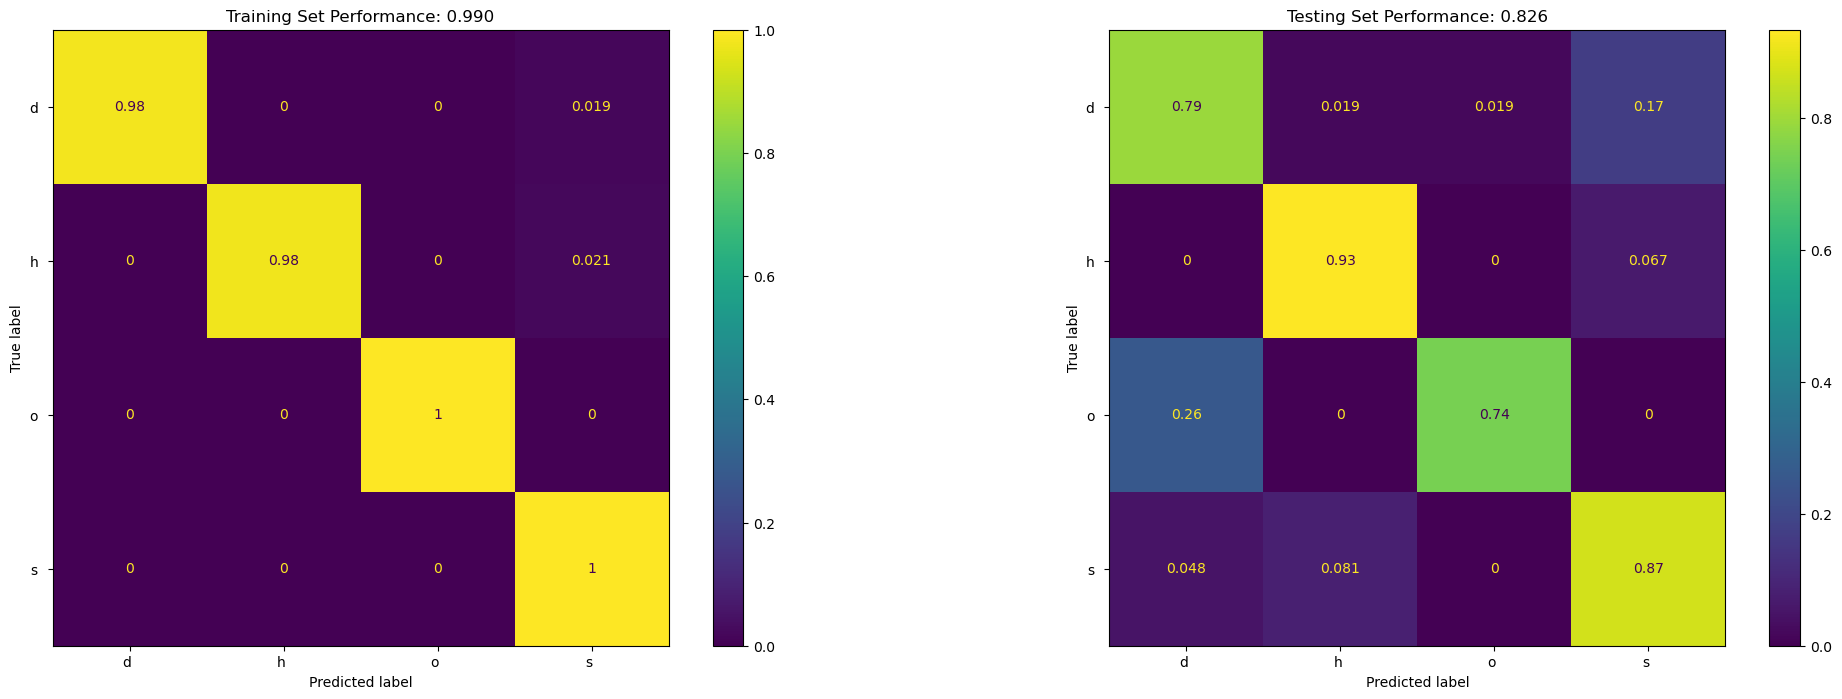

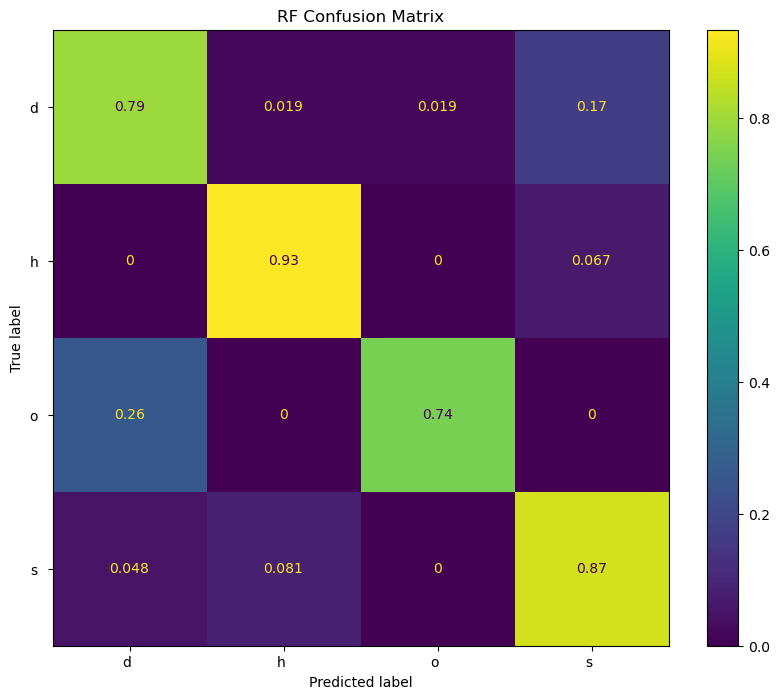

In [33]:
# Train your RF. You should consider the following parameters at least:
#  - Tree depth
#  - Number of estimators
# Please note, you'd don't need to find the "perfect" parameters. The grid search does not need to consider every possible value,
# and can be quite coarse to avoid long run-times. You may also wish to conduct a rough search first, and then a refined search, 
# though this is not required.

# Using Grid Search
param_grid = {
    'n_estimators': [2,10,100,150,200,300],
    'max_depth': [5,10,20,50],
}

# Set up the grid search
RF = RandomForestClassifier(class_weight='balanced',random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf = GridSearchCV(
    estimator= RF,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring = 'accuracy',
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_rf, X_train, Y_train, X_test, Y_test)
confusion_RF = eval_model_TEST(grid_search_rf, X_train, Y_train, X_test, Y_test, "RF Confusion Matrix")


# Determing Changes

In [ ]:
# Train your RF. You should consider the following parameters at least:
#  - Tree depth
#  - Number of estimators
# Please note, you'd don't need to find the "perfect" parameters. The grid search does not need to consider every possible value,
# and can be quite coarse to avoid long run-times. You may also wish to conduct a rough search first, and then a refined search, 
# though this is not required.

# Using Grid Search
param_grid = {
    'n_estimators': [10],
    'max_depth': [15],
}

# Set up the grid search
RF = RandomForestClassifier(class_weight='balanced',random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf = GridSearchCV(
    estimator= RF,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring = 'accuracy',
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_rf, X_train, Y_train, X_test, Y_test)


# Train your RF. You should consider the following parameters at least:
#  - Tree depth
#  - Number of estimators
# Please note, you'd don't need to find the "perfect" parameters. The grid search does not need to consider every possible value,
# and can be quite coarse to avoid long run-times. You may also wish to conduct a rough search first, and then a refined search, 
# though this is not required.

# Using Grid Search
param_grid = {
    'n_estimators': [10],
    'max_depth': [5],
}

# Set up the grid search
RF = RandomForestClassifier(class_weight='balanced',random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf = GridSearchCV(
    estimator= RF,
    param_grid=param_grid,
    cv=train_val_split,   # Use our PredefinedSplit for train vs. val
    scoring = 'accuracy',
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf.fit(X_train_and_val, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_rf, X_train, Y_train, X_test, Y_test)



# Determining if STD affects RF Model - ANS: NO SO we are going to use STD data for completeness

Best parameters found: {'max_depth': 5, 'n_estimators': 150}
              precision    recall  f1-score   support

          d        0.79      0.79      0.79        53
          h        0.72      0.87      0.79        15
          o        0.96      0.74      0.84        31
          s        0.82      0.87      0.84        62

    accuracy                           0.82       161
   macro avg       0.82      0.82      0.82       161
weighted avg       0.83      0.82      0.82       161



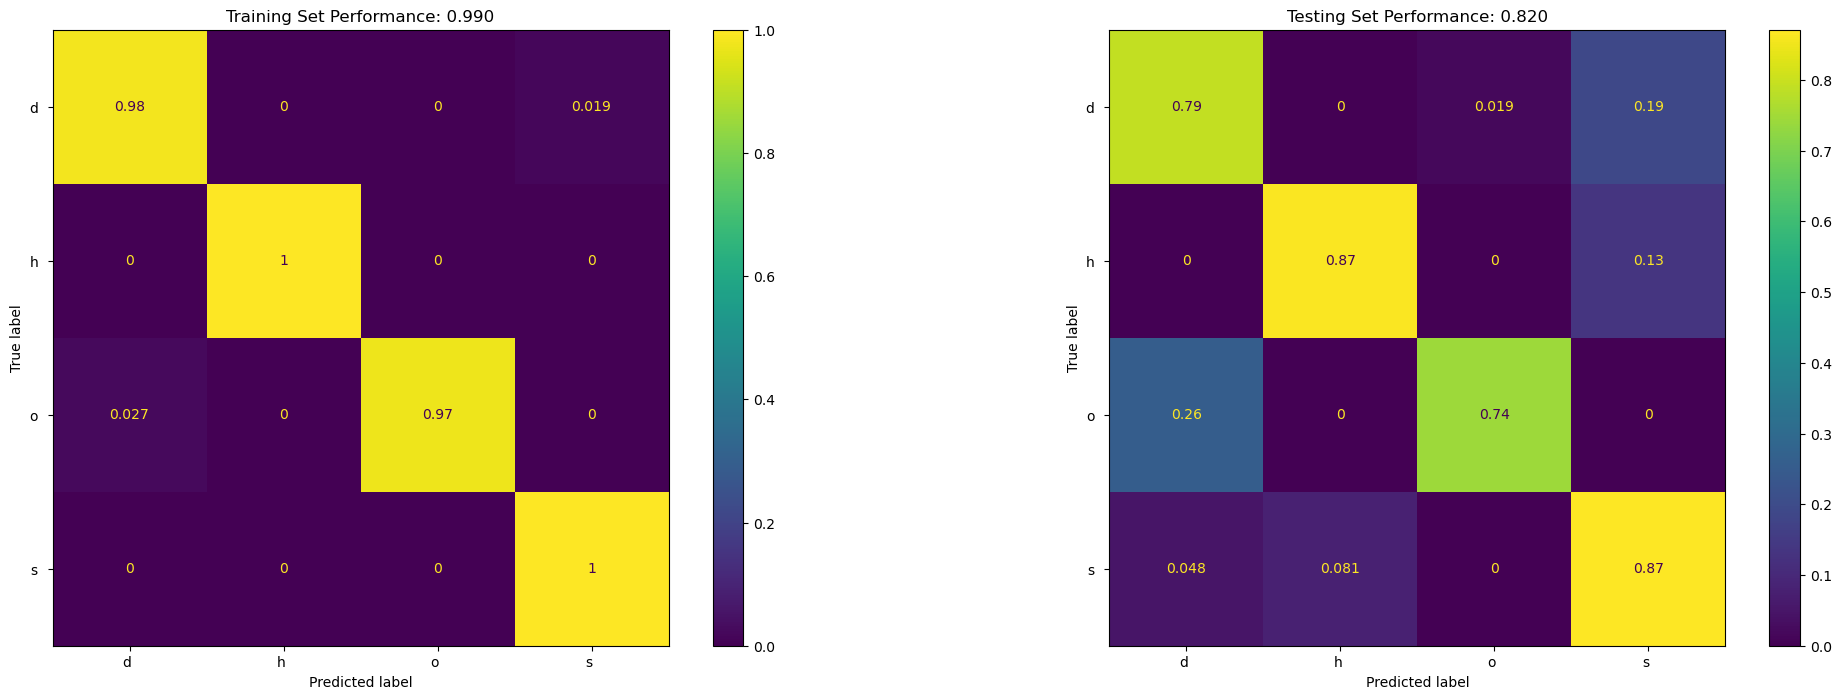

In [43]:
# Using Grid Search
param_grid = {
    'n_estimators': [100,150,200,300],
    'max_depth': [5,10,20,50],
}

# Set up the grid search
RF = RandomForestClassifier(random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf = GridSearchCV(
    estimator= RF,
    param_grid=param_grid,
    cv=train_val_split_std,   # Use our PredefinedSplit for train vs. val
    scoring = 'accuracy',
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_rf, X_train_std, Y_train, X_test_std, Y_test)

# RF Using Normalised

Best parameters found: {'max_depth': 10, 'n_estimators': 150}
              precision    recall  f1-score   support

          d        0.80      0.81      0.80        53
          h        0.68      0.87      0.76        15
          o        0.96      0.71      0.81        31
          s        0.85      0.89      0.87        62

    accuracy                           0.83       161
   macro avg       0.82      0.82      0.81       161
weighted avg       0.84      0.83      0.83       161



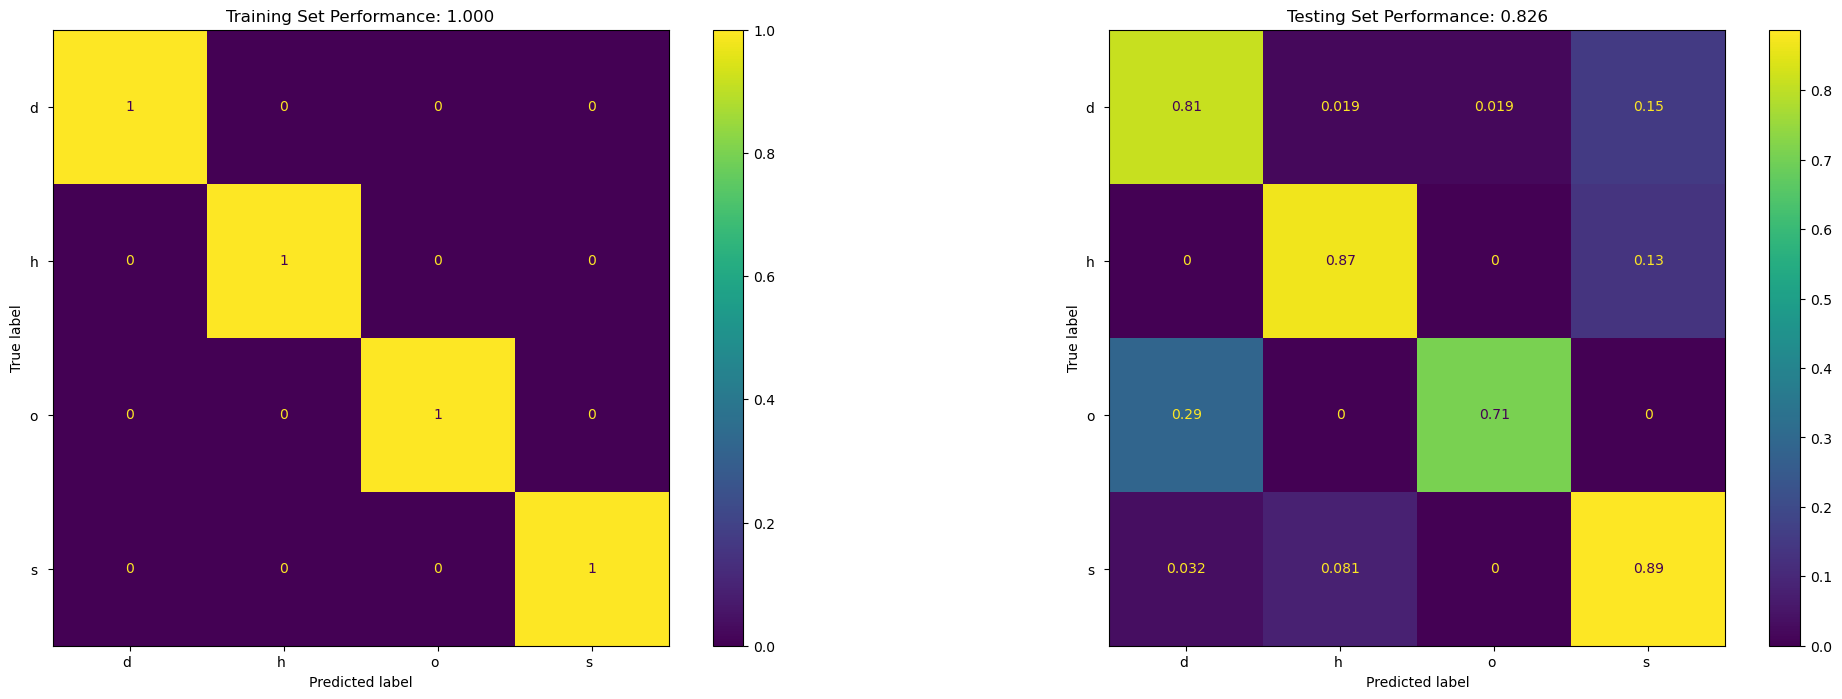

In [44]:
# Using Grid Search
param_grid = {
    'n_estimators': [100,150,200,300],
    'max_depth': [5,10,20,50],
}

# Set up the grid search
RF_norm = RandomForestClassifier(random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf_norm = GridSearchCV(
    estimator= RF_norm,
    param_grid=param_grid,
    cv=train_val_split_norm,   # Use our PredefinedSplit for train vs. val
    scoring = 'accuracy',
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf_norm.fit(X_train_and_val_norm, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf_norm.best_params_
print("Best parameters found:", best_params)
eval_model(grid_search_rf_norm, X_train_norm, Y_train, X_test_norm, Y_test)

# Refining Random Forest Model -> Barely a difference with performance, probably due to rounding

Best parameters found for search 2 depth[1,2,3,4,5] estimators[60,80,100,110,120]: {'max_depth': 4, 'n_estimators': 150}
              precision    recall  f1-score   support

          d        0.79      0.79      0.79        53
          h        0.72      0.87      0.79        15
          o        0.96      0.74      0.84        31
          s        0.82      0.87      0.84        62

    accuracy                           0.82       161
   macro avg       0.82      0.82      0.82       161
weighted avg       0.83      0.82      0.82       161



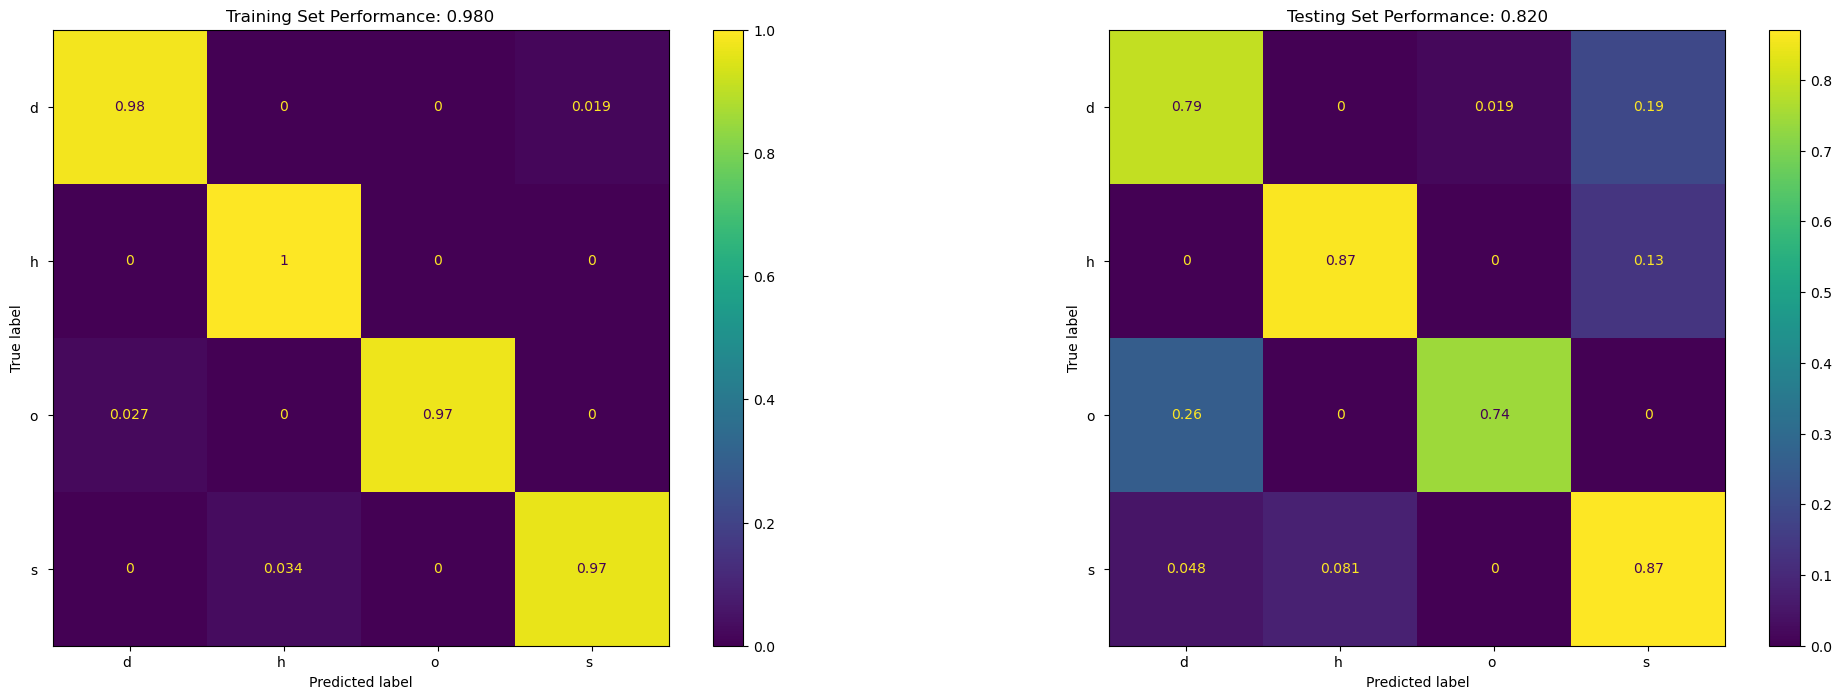

In [90]:
# Confining Search

param_grid = {
    'n_estimators': [150,170,190],
    'max_depth': [2,3,4,5,10],
}

# Set up the grid search
RF = RandomForestClassifier(random_state = 0)  # We'll let GridSearchCV try different params, we want the same split each time
grid_search_rf = GridSearchCV(
    estimator= RF,
    param_grid=param_grid,
    cv=train_val_split_std,   # Use our PredefinedSplit for train vs. val
    n_jobs=-1             # Use multiple cores if you can
)

# Run the grid search on the combined dataset
grid_search_rf.fit(X_train_and_val_std, Y_train_and_val)

# Identify the best parameters
best_params = grid_search_rf.best_params_
print("Best parameters found for search 2 depth[1,2,3,4,5] estimators[60,80,100,110,120]:", best_params)
eval_model(grid_search_rf, X_train_std, Y_train, X_test_std, Y_test)


In [ ]:
# Evaluate the three methods. This should consider appropriate performance measures for the classifiers, such as F1, and 
# visualisations of performance (i.e. confusion matrices) that demonstrate any difference in perfomance between the models.

In [ ]:
# For your write-up, you should include:
# - a discussion of any pre-processing you did and why; or why you left the data as-is
# - a discussion of how you selected the hyper-parameters for each of your models, and how these may be influenced by any data 
#   characteristics, and any effect you may see from the selected hyper-parameters (ie. if you have found a small value for a 
#   hyper parameter, what effect will this have on the model compared to a large value?) 
# - an evaluation and comparison of three models, which should highlight any differences observed between the models
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions.
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Function to plot testing confusion matrices for multiple models side by side
def eval_model_TEST(model, X_train, Y_train, X_test, Y_test, title='Testing Set Performance', ax=None):
    # Generate confusion matrix for the testing data
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    
    # Set the custom title for the testing confusion matrix
    conf.ax_.set_title(title)
    
    # Print the classification report for the test data
    print(classification_report(Y_test, model.predict(X_test)))
    
    # Return the testing confusion matrix for potential further use
    return conf.confusion_matrix

              precision    recall  f1-score   support

          d        0.80      0.74      0.76        53
          h        0.58      0.93      0.72        15
          o        0.95      0.61      0.75        31
          s        0.78      0.85      0.82        62

    accuracy                           0.78       161
   macro avg       0.78      0.78      0.76       161
weighted avg       0.80      0.78      0.78       161

              precision    recall  f1-score   support

          d        0.88      0.92      0.90        53
          h        0.70      0.93      0.80        15
          o        0.96      0.81      0.88        31
          s        0.93      0.89      0.91        62

    accuracy                           0.89       161
   macro avg       0.87      0.89      0.87       161
weighted avg       0.90      0.89      0.89       161

              precision    recall  f1-score   support

          d        0.79      0.79      0.79        53
          h        0.

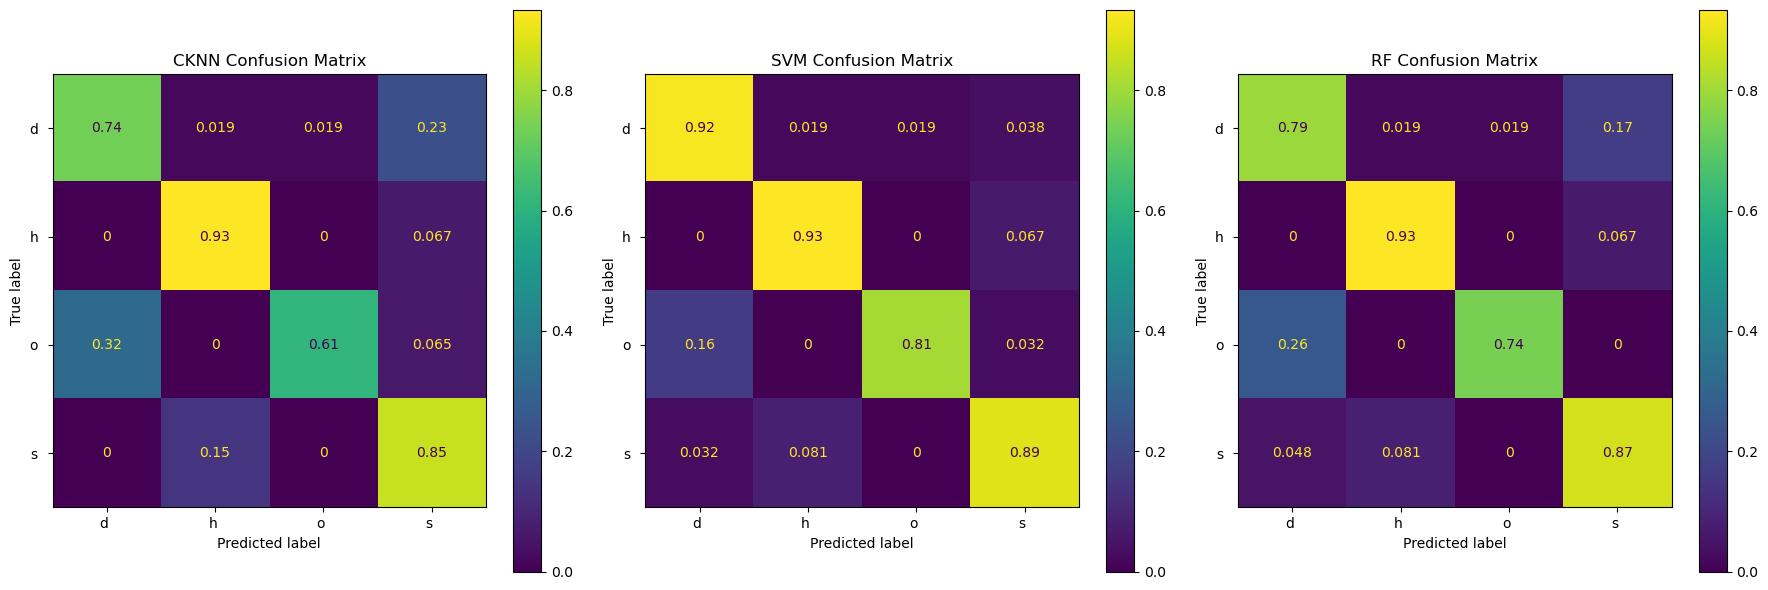

In [42]:
# Create a figure with subplots side by side (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=[18, 6])  # Adjust figsize for better spacing

# List of models and titles
models = [grid_search_cknn, grid_search_svm, grid_search_rf]
titles = ['Testing Set: CKNN Confusion Matrix', 'SVM Confusion Matrix', 'RF Confusion Matrix']

# Loop through the models and add each testing confusion matrix to the subplots
for model, title, ax in zip(models, titles, axes):
    # Pass the specific axis to the eval_model_TEST function for each model
    eval_model_TEST(model, X_train, Y_train, X_test, Y_test, title=title, ax=ax)

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()  # Display the final plot with confusion matrices for all models